In [15]:
# Standard lib imports
import csv
from collections import OrderedDict, Counter
from os import access, R_OK
import sys
from gzip import open as gopen
import warnings
from time import time
from statistics import median
from glob import glob

# Local lib import
import pycl
import pyBioPlot as pbp
import pyBioUtil as pbu
from pycl import head as h

# Third party import
import pandas as pd
import numpy as np
import pylab as pl
import pysam
from matplotlib.patches import FancyArrowPatch as arrow
from matplotlib.cm import get_cmap
from matplotlib.gridspec import GridSpec

# Jupyter specific imports
from IPython.core.display import display, HTML, Markdown, Image

# Pyplot tweaking
%matplotlib inline
pl.rcParams['figure.figsize'] = 30, 10  # that's default image size for this interactive session

# Jupyter display tweaking 
pycl.toogle_code()
pycl.larger_display(90)

# Simplify warning reporting to lighten the notebook style 
warnings.formatwarning=(lambda message, *args: "{}\n".format(message))

### Folder setup and download test files

In [13]:
print ("Create directory for the test dataset files")
!mkdir -p "./test_data/"

Create directory for the test dataset files


In [14]:
print ("Download reference human genome from Gencode")
!wget "ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_human/release_25/GRCh38.primary_assembly.genome.fa.gz" -O "./test_data/GRCh38_primary.fa.gz"

Download reference human genome from Gencode
--2016-10-19 17:43:34--  ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_human/release_25/GRCh38.primary_assembly.genome.fa.gz
           => ‘./test_data/GRCh38_primary.fa.gz’
Resolving ftp.sanger.ac.uk (ftp.sanger.ac.uk)... 193.62.203.17
Connecting to ftp.sanger.ac.uk (ftp.sanger.ac.uk)|193.62.203.17|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/gencode/Gencode_human/release_25 ... done.
==> SIZE GRCh38.primary_assembly.genome.fa.gz ... 844691642
==> PASV ... done.    ==> RETR GRCh38.primary_assembly.genome.fa.gz ... done.
Length: 844691642 (806M) (unauthoritative)

GRCh38.primary_asse 100%[===================>] 805.56M  2.46MB/s    in 7m 36s  

2016-10-19 17:51:11 (1.77 MB/s) - ‘./test_data/GRCh38_primary.fa.gz’ saved [844691642]



In [15]:
print ("Download reference gencode v25 human genome annotation")
!wget "ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_human/release_25/gencode.v25.primary_assembly.annotation.gff3.gz" -O "./test_data/gencode_v25_primary.gff3.gz"

Download reference gencode v25 human genome annotation
--2016-10-19 17:51:11--  ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_human/release_25/gencode.v25.primary_assembly.annotation.gff3.gz
           => ‘./test_data/gencode_v25_primary.gff3.gz’
Resolving ftp.sanger.ac.uk (ftp.sanger.ac.uk)... 193.62.203.17
Connecting to ftp.sanger.ac.uk (ftp.sanger.ac.uk)|193.62.203.17|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/gencode/Gencode_human/release_25 ... done.
==> SIZE gencode.v25.primary_assembly.annotation.gff3.gz ... 46752876
==> PASV ... done.    ==> RETR gencode.v25.primary_assembly.annotation.gff3.gz ... done.
Length: 46752876 (45M) (unauthoritative)

gencode.v25.primary 100%[===================>]  44.59M  2.45MB/s    in 25s     

2016-10-19 17:51:39 (1.81 MB/s) - ‘./test_data/gencode_v25_primary.gff3.gz’ saved [46752876]



In [16]:
print ("Download reference gencode v25 human genome annotation")
!wget "ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_human/release_25/gencode.v25.primary_assembly.annotation.gtf.gz" -O "./test_data/gencode_v25_primary.gtf.gz"

Download reference gencode v25 human genome annotation
--2016-10-19 17:51:39--  ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_human/release_25/gencode.v25.primary_assembly.annotation.gtf.gz
           => ‘./test_data/gencode_v25_primary.gtf.gz’
Resolving ftp.sanger.ac.uk (ftp.sanger.ac.uk)... 193.62.203.17
Connecting to ftp.sanger.ac.uk (ftp.sanger.ac.uk)|193.62.203.17|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/gencode/Gencode_human/release_25 ... done.
==> SIZE gencode.v25.primary_assembly.annotation.gtf.gz ... 38827267
==> PASV ... done.    ==> RETR gencode.v25.primary_assembly.annotation.gtf.gz ... done.
Length: 38827267 (37M) (unauthoritative)

gencode.v25.primary 100%[===================>]  37.03M  2.40MB/s    in 20s     

2016-10-19 17:51:59 (1.83 MB/s) - ‘./test_data/gencode_v25_primary.gtf.gz’ saved [38827267]



In [17]:
print ("Download reference gencode v25 human genome annotation")
!wget "http://www.noncode.org/datadownload/NONCODE2016_human_hg38_lncRNA.gtf.gz" -O "./test_data/NONCODE2016_human_hg38_lncRNA.gtf.gz"

Download reference gencode v25 human genome annotation
--2016-10-19 17:51:59--  http://www.noncode.org/datadownload/NONCODE2016_human_hg38_lncRNA.gtf.gz
Resolving www.noncode.org (www.noncode.org)... 112.124.13.146
Connecting to www.noncode.org (www.noncode.org)|112.124.13.146|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8248713 (7.9M) [application/x-gzip]
Saving to: ‘./test_data/NONCODE2016_human_hg38_lncRNA.gtf.gz’

./test_data/NONCODE 100%[===================>]   7.87M  45.0KB/s    in 3m 8s   

2016-10-19 17:55:17 (42.8 KB/s) - ‘./test_data/NONCODE2016_human_hg38_lncRNA.gtf.gz’ saved [8248713/8248713]



In [18]:
print ("Download example bam file")
!wget -v "http://www.ebi.ac.uk/~aleg/data/share/1M_sample.bam" -O "./test_data/1M_sample.bam"

Download example bam file
--2016-10-19 17:55:17--  http://www.ebi.ac.uk/~aleg/data/share/1M_sample.bam
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134778245 (129M) [text/plain]
Saving to: ‘./test_data/1M_sample.bam’

./test_data/1M_samp 100%[===================>] 128.53M  4.01MB/s    in 37s     

2016-10-19 17:55:54 (3.51 MB/s) - ‘./test_data/1M_sample.bam’ saved [134778245/134778245]



In [19]:
print ("Download example bam file")
!wget -v "http://www.ebi.ac.uk/~aleg/data/share/10M_sample.bam" -O "./test_data/10M_sample.bam"

Download example bam file
--2016-10-19 17:55:54--  http://www.ebi.ac.uk/~aleg/data/share/10M_sample.bam
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1094706685 (1.0G) [text/plain]
Saving to: ‘./test_data/10M_sample.bam’

./test_data/10M_sam 100%[===================>]   1.02G  4.16MB/s    in 5m 21s  

2016-10-19 18:01:15 (3.26 MB/s) - ‘./test_data/10M_sample.bam’ saved [1094706685/1094706685]



## First prototype of the class

In [3]:
#~~~~~~~GENERIC HELPER FUNCTIONS~~~~~~~#

def get_extensions (fp):
    """ 
    Return The extension of a file in lower-case. If archived file "gz"
    the method will output the base extension + the archive extension
    """
    split_name = fp.split("/")[-1].split(".")
    # No extension ? 
    if len (split_name) == 1:
        return ""
    # Manage compressed files
    elif len (split_name) > 2 and split_name[-1].lower() == "gz":
        return ".{}.{}".format(split_name[-2], split_name[-1]).lower()
    # Normal situation = return the last element of the list
    else:
        return ".{}".format(split_name[-1]).lower()
    
def get_basename (fp):
    """ 
    Return The extension of a file in lower-case. If archived file "gz"
    the method will output the base extension + the archive extension
    """
    split_name = fp.split("/")[-1].split(".")
    # No extension ? 
    if len (split_name) == 1:
        return split_name[0]
    # Manage compressed files
    elif len (split_name) > 2 and split_name[-1].lower() == "gz":
        return ".".join(split_name[0:-2])
    # Normal situation = return the last element of the list
    else:
        return ".{}".format(split_name[0]).lower()

def is_readable_file (fp):
    """
    Verify the readability of a file or list of file
    """
    return access(fp, R_OK)
        
def color_palette(n, colormap="brg"):
    """
    Return a list of l length with gradient colors from a given matplot lib colormap palette
    * n         Number of color scalar in the list
    * colormap  colormap color palette from matplotlib package see http://matplotlib.org/examples/color/colormaps_reference.html
                example : inferno magma hot blues cool spring winter brg ocean hsv jet ... [DEFAULT: brg]
    """
    # Init variables
    cmap = get_cmap(colormap)
    index = 1 # skip the first value 
    n_col_cmap = cmap.N-2 # remove border colors
    step = int(n_col_cmap/(n-1)) if n > 1 else n_col_cmap/2
    
    # Create the list of colors
    cl = []
    for i in range (n):
        cl.append(cmap(index))
        index+=step
    return cl
        
#~~~~~~~HELPER CLASSES~~~~~~~#

class gff3_line(object):
    def __init__ (self, pysam_gff_line):
        self.contig = pysam_gff_line.contig
        self.source = pysam_gff_line.source
        self.start = pysam_gff_line.start
        self.end = pysam_gff_line.end
        self.strand = pysam_gff_line.strand
        self.score = pysam_gff_line.score
        self.frame = pysam_gff_line.frame
        self.feature = pysam_gff_line.feature
        self.true_start = self.start if self.strand == "+" else self.end
        self.true_end = self.end if self.strand == "+" else self.start 
        
        for attribute in pysam_gff_line.attributes.split(";"):
            k,v = attribute.split("=")
            self.__dict__[k] = v
            
    def __str__(self):
        """readeable description of the object"""
        msg = "{} instance\n".format(self.__class__.__name__) 
        msg+= "\tParameters list\n"
        # list all values in object dict in alphabetical order
        sorted_d = OrderedDict(sorted(self.__dict__.items(), key=lambda t: t[0]))
        for k,v in sorted_d.items():
            msg+="\t{}\t{}\n".format(k, v)
        return (msg)

#~~~~~~~MAIN CLASS~~~~~~~#
    
class JGV(object):
    
    #~~~~~~~FUNDAMENTAL METHODS~~~~~~~#
    
    def __init__ (self, fasta=None, index=None, verbose=False):
        """
        Create an JGV reference containing a list of seqid retrieved from a fasta file or a fasta index file (fai).
        One of the 2 files has to be given to initialise the object.
        * fasta     A fasta file containing the reference sequences. The file will be parsed to get the name and length
                    of the sequences, but the sequence per se do not need to be saved. A tab separated file containing the name of
                    the sequences and the length will be written in the same dir as the fasta file. this file can be used latter as
                    an index file. Can be gziped or not 
        * index     A file containing at least 2 columns with the seqid and the length in base. It could be a fai file generated
                    by samtools faidx or any other tab separated format. This option is much faster than the fasta option.
                    Can be gziped or not
        * verbose   If True, will print more information during execution
        """
        self.verbose = verbose
        
        if not fasta and not index:
            raise ValueError ("A fasta file or a fasta index has to be given")
        
        if self.verbose: print("Initialize JGV with a reference genome")
        
        if fasta:
            if self.verbose: print("\tReading fasta file and extracting sequence information")
            # Verify that the file is readable and in fasta format 
            if not is_readable_file (fasta):
                raise IOError ("{} is not readable".format(fasta))
            # Verify that the file is in fasta format
            if get_extensions(fasta) not in [".fa", ".fasta", ".fa.gz", ".fasta.gz"]:
                raise ValueError ("The file is not in fasta format(.fa or .fasta +- .gz). Please provide a correctly formated file")
            # Parse and save a dict with the seqid and the length of each sequence
            self.seqid_dict = self._fasta_parser(fasta)
            # Write an index file for latter
            filename = fasta[:-len(get_extensions(fasta))]+"_index.tsv"
            if self.verbose: print("\tWriting an index file")
            with open(filename,'w') as csvfile:
                w = csv.writer(csvfile, delimiter='\t')
                w.writerows(self.seqid_dict.items())
                
        if index:
            if self.verbose: print("\tReading index file and extracting sequence information")
            # Verify that the file is readable
            if not is_readable_file (index):
                raise IOError ("{} is not readable".format(index))
            # Parse and save a dict with the seqid and the length of each sequence
            self.seqid_dict = self._index_parser(index)
        
        if self.verbose: print("\tTotal number of sequences found: {}".format(len(self.seqid_dict)))
        
        # Init empty
        self.annotation_dict = OrderedDict()
        self.alignment_dict = OrderedDict()        
            
    def __str__(self):
        """readeable description of the object"""
        msg = "{} instance\n".format(self.__class__.__name__)
        msg+= "\tParameters list\n"
        # list all values in object dict in alphabetical order
        sorted_d = OrderedDict(sorted(self.__dict__.items(), key=lambda t: t[0]))
        for k,v in sorted_d.items():
            msg+= "\t{}\t{}\n".format(k, v)
        return (msg)
                                  
    #~~~~~~~PRIVATE METHODS~~~~~~~#
    
    def _fasta_parser (self, fp):
        """ Parse a fasta file and return a dict """
        f = None
        try:
            f = gopen(fp, "rt") if fp.endswith(".gz") else open(fp, "r")
            c = Counter()
            for l in f:
                if l.startswith(">"):
                    seqid = l[1:].split()[0].strip()
                else:
                    c[seqid]+=len(l.strip())
        finally:
            if f:
                f.close()
        return OrderedDict(c)
    
    def _index_parser (self, fp):
        """ Parse a fasta file and return a dict """
        f = None
        try:
            f = gopen(fp, "rt") if fp.endswith(".gz") else open(fp, "r")
            d = OrderedDict()
            for l in f:
                ls = l.split("\t")
                assert len(ls) >= 2, "The index file is incorectly formated"
                seqid = ls[0].strip()
                length = int(ls[1].strip())
                d[seqid] = length
        finally:
            if f:
                f.close()       
        return d              
    #~~~~~~~PUBLIC METHODS~~~~~~~#
    
    def add_annotation (self, fp, name=None):
        """
        * fp A standard gff3 file (http://www.ensembl.org/info/website/upload/gff3.html) containing all feature annotation.
                                Could be uncompressed or achived in the following format ("gz"). Ideally already indexed
                                with tabix bgzip. If not the programm will sort the features and index the file (can takes time)
        """
        # Verify that the file is readable
        if not is_readable_file (fp):
            raise IOError ("{} is not readable".format(fp))
        # Extract basename and extension for further 
        extension = get_extensions(fp)
        if not name:
            name = get_basename(fp)
        # Verify that the file is in gff3 format
        if extension not in [".gff3.gz", ".gff3"]:
            raise ValueError ("The file is not in gff3 format (.gff3.gz, .gff3). Please provide a correctly formated file")

        # If not indexed, sort and compress and index the original file with tabix 
        if not is_readable_file (fp+".tbi"):
           
            # Import in a panda dataframe, remove empty row, and convert coordinates in integer
            if self.verbose:  print("Indexing file with tabix\n\tImport annotation file and clean data")
            df = pd.read_csv(fp, names=["seqname","source","feature","start","stop","score","strand","frame","attribute"], sep="\t")
            df.dropna(inplace=True)
            df[['start', 'stop']] = df[['start', 'stop']].astype(int)
            
            # Sort the dataframe
            if self.verbose: print("\tSort lines by coordinates")
            df.sort_values(by=["seqname","start","stop"], inplace=True)
            # Remove the extension, name the output file and write in file
            temp_file = fp[:-len(extension)]+"_sorted.gff3"
            df.to_csv(temp_file, sep="\t", header=False, index=False)
            
            # Compress and index the sorted file with tabix
            if self.verbose: print("\tCompress and index with tabix")
            fp = pysam.tabix_index(temp_file, preset="gff", force=True)
        
        # Common steps if existing or generated index
        with pysam.TabixFile(fp, parser=pysam.asGTF()) as gff:
            if self.verbose: print("Gff file indexed")
            # Verify the sequence id 
            for seqid in [i.decode() for i in gff.contigs]:
                if seqid not in self.seqid_dict:
                    warnings.warn("{} seqid from annotation file not found in the initial fasta file".format(seqid))
            self.annotation_dict[name] = gff.filename.decode()
    
    def add_alignment (self, fp, name=None):
        """
        * fp        A standard BAM formated file containing aligned short reads SORTED. Ideally the file would also be indexed
        """
        # Verify that the file is readable
        is_readable_file (fp)
        # Extract basename and extension for further 
        extension = get_extensions(fp)
        if not name:
            name = get_basename(fp)
        # Verify that the file is in bam format
        if extension not in [".bam"]:
            raise ValueError ("The file is not in BAM format (.bam). Please provide a correctly formated file")
        
        with pysam.AlignmentFile(fp) as bam:
            # If not bam index available
            if not bam.has_index():
                # If no index but file sorted
                if bam.header["HD"]['SO'] == "coordinate":
                    if self.verbose: print("Indexing bam file")
                    pysam.index(fp, catch_stdout=False)
                else:
                    raise UserWarning ("The file bam needs to be sorted by coordinates to be processed")
            
            assert bam.has_index(), "Bam file is not indexed ?"
            if self.verbose: print("Bam file indexed")
            for seqid in bam.references:
                if seqid not in self.seqid_dict:
                    warnings.warn("{} seqid from annotation file not found in the initial fasta file".format(seqid))
            self.alignment_dict[name] =  bam.filename.decode()    
    
    def plot_interval(self,
        seqid, start=None, end=None,
        alignment_tracks=[],
        alignment_n_step=500,
        alignment_yscale="linear",
        alignment_mode="auto",
        annotation_tracks=[],
        annotation_feature_types=[],
        annotation_label=False,
        annotation_overlap_offset=None,
        annotation_max_level=None,
        plot_style="ggplot",
        track_width=30,
        alignment_track_height=10,
        annotation_track_height=2):
        """
        """
        
        # Verify that the requested seqid is in the file and check the start and end coordinates
        # Get coordinates if not given and verify the given coordinates
        if self.verbose: print ("Check coordinates")
        if not seqid in self.seqid_dict:
            raise UserWarning ("Seqid {} not found in the reference file".format(seqid))
        if not start or start < 0:
            start = 0         
        if not end or end > self.seqid_dict[seqid]:
            end = self.seqid_dict[seqid]    
        if start >= end:
            raise UserWarning ("Invalid start end coordinates".format(seqid))
        
        # Parse alignment
        if self.verbose: print ("Parse alignment files")
        if not alignment_tracks:
            alignment_tracks = self.alignment_dict.keys()
        alignment_track_dict = OrderedDict()
        alignment_track_count = 0
        for track_name in alignment_tracks:
            d = self.parse_alignment(
                track_name=track_name,
                seqid=seqid,
                start=start,
                end=end,
                n_step=alignment_n_step,
                mode=alignment_mode)
            alignment_track_count += len(d)
            alignment_track_dict[track_name] = d
        
        # Parse annotations
        if self.verbose: print ("Parse annotation files")
        if not annotation_tracks:
            annotation_tracks = self.annotation_dict.keys()
        annotation_track_dict = OrderedDict()
        annotation_track_count = 0
        for track_name in annotation_tracks:
            d = self.parse_annotation (
                track_name=track_name,
                seqid=seqid,
                start=start,
                end=end,
                feature_types=annotation_feature_types,
                overlap_offset=annotation_overlap_offset,
                max_level=annotation_max_level)
            annotation_track_count += len(d)
            annotation_track_dict[track_name] = d
            
        # Prepare the multipannel figure for plotting
        total_height = alignment_track_count*(alignment_track_height+1)
        total_height+= annotation_track_count*annotation_track_height + len(annotation_track_dict)

        pl.style.use(plot_style)
        fig = pl.figure(figsize=(track_width, total_height), frameon=False)
        grid = GridSpec(total_height, 1, hspace=0.01)
        
        # Initial level for the first subplot
        h=0
        if self.verbose: print ("Plot alignment tracks")
        for track_name, coord_dict in alignment_track_dict.items():
            if self.verbose: print ("\tTrack name: {}".format(track_name))
            h+=1
            # Define the ploting area for the current track
            subplot = pl.subplot(grid[h:h+alignment_track_height])
            h+=alignment_track_height
                    
            # Tweak the subplot
            subplot.set_xlim((start, end))
            subplot.yaxis.set_tick_params(left=False, right=False, labelleft=True, labelright=False)
            subplot.xaxis.set_tick_params(bottom=False, top=False, labelbottom=True, labeltop=False)
            subplot.ticklabel_format(useOffset=False, style='plain')
            subplot.set_title(track_name)
            
            if alignment_yscale == "log":
                if any(coord_dict["y"]) <= 0:
                    warnings.warn("Data has no positive values, and therefore can not be log-scaled.")
                else:
                    subplot.set_yscale("log")
            
            # Plot the area
            subplot.fill_between(coord_dict["x"], 0, coord_dict["y"])
        
        if self.verbose: print ("Plot annotation tracks")
        for track_name, feature_dict in annotation_track_dict.items():
            color_list = color_palette(len(feature_dict) ,"Set2")
            if self.verbose: print ("\tTrack name: {}".format(track_name))
            h+=1
            for i, (feature_type, level_dict) in enumerate(feature_dict.items()):
                if self.verbose: rint ("\t\tPloting feature: {}".format(feature_type))
                
                # Define the ploting area for the current track
                subplot = pl.subplot(grid[h:h+annotation_track_height])
                h+=annotation_track_height
                
                # Tweak the subplot
                subplot.set_xlim((start, end))
                subplot.set_ylim((0, len(level_dict)+1))
                subplot.yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=False)
                subplot.ticklabel_format(useOffset=False, style='plain')
                subplot.set_ylabel(feature_type)
                subplot.grid(axis="y", b=False)
                # Title only for first line
                if i == 0:
                    subplot.set_title(track_name)
                # xlabel only for last line
                if i == len(feature_dict)-1:
                    subplot.xaxis.set_tick_params(bottom=False, top=False, labelbottom=True, labeltop=False)
                else:
                    subplot.xaxis.set_tick_params(bottom=False, top=False, labelbottom=False, labeltop=False)
                
                for level, list_line in level_dict.items():                   
                    for line in list_line:
                        # Scale the arrow depending of the number of lines
                        arrowstyle = "{style},head_width={width},head_length={lenght}".format(
                            style="-|>",  width=6/len(level_dict)+1, lenght=12/len(level_dict)+1)

                        # Plot the arrow
                        subplot.add_patch(arrow (
                            posA=[line.true_start,level+1],
                            posB=[line.true_end,level+1],
                            arrowstyle=arrowstyle,
                            linewidth=12/len(level_dict)+1,
                            edgecolor=color_list[i],
                            facecolor=color_list[i]))
                        # Add text
                        if annotation_label:
                            mid = line.true_start+(line.true_end-line.true_start)/2
                            if start <= mid <= end:
                                subplot.text (x=mid, y=level+1, s=line.ID, horizontalalignment="center")
        

    def parse_alignment (self, track_name, seqid, start=0, end=100000, n_step=500, mode="auto"):
        """
        * force_mode "auto" or "read_count" or "base_coverage"
        """
        fp = self.alignment_dict[track_name]
        
        # Autocorect the step if needed to be always <= to the requested interval
        d = OrderedDict()
        d["x"] = []
        d["y"] = []
        len_range = end-start
        if n_step > len_range:
            n_step = len_range
            warnings.warn("Short interval = autocorect n_step to {}".format(n_step))
        step_size = (end-start) / float(n_step)

        # Count method is less accurate but much quicker for very long intervals.
        # Do not take into account spliced sites, ie read will be represented from their first mapped
        # to their last base
        
        if mode == "read_count" or (mode == "auto" and len_range > 5000000):
            if self.verbose:
                print("Select read_count mode") 
            start_pos = start
            with pysam.AlignmentFile(fp) as bam:
                for i in range(n_step):

                    d["x"].append(round(start_pos))
                    d["y"].append(bam.count(seqid, start_pos, start_pos+step_size))

                    start_pos+=step_size

        # Coverage method is more precise and quicker for smaller intervals but become really slow when > 5000000
        elif mode == "base_coverage" or (mode == "auto" and len_range <= 5000000):
            if self.verbose:
                print("Select base_coverage mode")
            with pysam.AlignmentFile(fp) as bam:
                mat = bam.count_coverage(seqid, start, end)
                start_pos = 0
                while start_pos <= len_range-step_size:            
                    s = round(start_pos)
                    e = round(start_pos+step_size)

                    d["x"].append(round(start+start_pos))
                    d["y"].append(median(mat[0][s:e])+sum(mat[1][s:e])+sum(mat[2][s:e])+sum(mat[3][s:e]))

                    start_pos+=step_size
        return d

    def parse_annotation (self, track_name, seqid, start=0, end=100000, feature_types=[], overlap_offset=None, max_level=None):
        """
        """
        fp = self.annotation_dict[track_name]
        with pysam.TabixFile(fp, parser=pysam.asGTF()) as f:

            # Verify that the required seqid is in the file.
            if not seqid in [i.decode() for i in f.contigs]:
                warnings.warn ("No Annotation available for the requested seqid")
                return None

            # Define the list of features types in the requested interval
            if self.verbose:
                print ("Find features in the given coordinates") 
            feature_counter = Counter()
            for line in f.fetch(seqid, start, end, parser=pysam.asGTF()):
                feature_counter[line.feature]+=1
                
            # Save all feature types if not defined or verify if the requested feature types were found
            d = OrderedDict()
            for ft in sorted(feature_counter.keys()):
                if not feature_types or ft in feature_types:
                    d[ft] = OrderedDict()
                    
            # No feature found
            if not feature_counter:
                warnings.warn ("No feature found in the requested interval")
                return
            elif self.verbose:
                print ("Valid feature types found in the requested interval: {}".format(", ".join(feature_types)))

            # Calculate overlap_offset if not given
            if not overlap_offset:
                overlap_offset = int((end-start)/400)
                if self.verbose:
                    print ("Estimated overlap offset: {}".format(overlap_offset))
            
            # Parse and collect the lines corresponding to each feature type
            for ft in d.keys():
                
                if self.verbose:
                    print("Feature type: {}".format(ft)) 
                    print("\tCollect gff lines")

                # Collect in a multi level dictionnary corresponding to non overlapping features
                # Fit as much lines as possible without overlaping + offset  for compact graphical representation
                n_total = n_saved = 0
                for line in f.fetch(seqid, start, end, parser=pysam.asGTF()):
                    if line.feature == ft:
                        n_total+=1

                        # Add each feature line to the lowest level without overlaping. Starting from level 0, check if the new
                        # feature line can fit without overlapping an existing feature. If not go to the upper level and check again...
                        # If all existing level are already full create the next level and add the feature line. 
                        # If the level is higher than "max_level", the feature is discarded
                        level = 0
                        while True:
                            # If last level = break
                            if max_level and level >= max_level:
                                break
                            # If existing level try to fit the feature line
                            elif level in d[ft]:
                                if d[ft][level][-1].end+overlap_offset < line.start:
                                    d[ft][level].append(gff3_line(line))
                                    n_saved+=1
                                    break
                                # if does not fit increment the level
                                level+=1
                            # Create a new level if needed  
                            else:
                                d[ft][level]=[gff3_line(line)]
                                n_saved+=1
                                break
                if self.verbose:
                    print ("\t\tTotal line: {}\t".format(n_total))
                    print ("\t\tFiltered line: {}\t".format(n_saved))
                    print ("\t\tTotal number of levels: {}\t".format(len(d[ft])))
                    print("\tPlot gff lines")
            
        return d
    

In [245]:
f = "./test_data/ERCC.fa"
print(JGV(fasta=f, verbose=True))

Initialize JGV with a reference genome
	Reading fasta file and extracting sequence information
	Writing an index file
	Total number of sequences found: 96
JGV instance
	Parameters list
	alignment_dict	OrderedDict()
	annotation_dict	OrderedDict()
	seqid_dict	OrderedDict([('ERCC-00116', 1991), ('ERCC-00137', 537), ('ERCC-00028', 1130), ('ERCC-00033', 2022), ('ERCC-00142', 493), ('ERCC-00117', 1136), ('ERCC-00079', 644), ('ERCC-00078', 993), ('ERCC-00059', 525), ('ERCC-00168', 1024), ('ERCC-00160', 743), ('ERCC-00130', 1059), ('ERCC-00108', 1022), ('ERCC-00162', 523), ('ERCC-00043', 1023), ('ERCC-00154', 537), ('ERCC-00096', 1107), ('ERCC-00009', 984), ('ERCC-00143', 784), ('ERCC-00120', 536), ('ERCC-00013', 808), ('ERCC-00040', 744), ('ERCC-00126', 1118), ('ERCC-00058', 1136), ('ERCC-00007', 1135), ('ERCC-00104', 2022), ('ERCC-00073', 603), ('ERCC-00084', 994), ('ERCC-00095', 521), ('ERCC-00044', 1156), ('ERCC-00039', 740), ('ERCC-00002', 1061), ('ERCC-00170', 1023), ('ERCC-00046', 522),

In [246]:
f = "./test_data/ERCC_index.tsv"
print(JGV(index=f, verbose=True))

Initialize JGV with a reference genome
	Reading index file and extracting sequence information
	Total number of sequences found: 96
JGV instance
	Parameters list
	alignment_dict	OrderedDict()
	annotation_dict	OrderedDict()
	seqid_dict	OrderedDict([('ERCC-00116', 1991), ('ERCC-00137', 537), ('ERCC-00028', 1130), ('ERCC-00033', 2022), ('ERCC-00142', 493), ('ERCC-00117', 1136), ('ERCC-00079', 644), ('ERCC-00078', 993), ('ERCC-00059', 525), ('ERCC-00168', 1024), ('ERCC-00160', 743), ('ERCC-00130', 1059), ('ERCC-00108', 1022), ('ERCC-00162', 523), ('ERCC-00043', 1023), ('ERCC-00154', 537), ('ERCC-00096', 1107), ('ERCC-00009', 984), ('ERCC-00143', 784), ('ERCC-00120', 536), ('ERCC-00013', 808), ('ERCC-00040', 744), ('ERCC-00126', 1118), ('ERCC-00058', 1136), ('ERCC-00007', 1135), ('ERCC-00104', 2022), ('ERCC-00073', 603), ('ERCC-00084', 994), ('ERCC-00095', 521), ('ERCC-00044', 1156), ('ERCC-00039', 740), ('ERCC-00002', 1061), ('ERCC-00170', 1023), ('ERCC-00046', 522), ('ERCC-00156', 494), (

In [254]:
f = "./test_data/GRCh38_p7_genome.fa.gz"
a = JGV(fasta=f, verbose=True)

g = "./test_data/gencode_v25_annotation.gff3.gz"
a.add_annotation(g)
g2 = "./test_data/gencode_v25_long_noncoding_RNAs.gff3.gz"
a.add_annotation(g2)

print(a)

Initialize JGV with a reference genome
	Reading fasta file and extracting sequence information
	Writing an index file
	Total number of sequences found: 524
Indexing file with tabix
	Import annotation file and clean data
	Sort lines by coordinates
	Compress and index with tabix
Gff file indexed
Indexing file with tabix
	Import annotation file and clean data
	Sort lines by coordinates
	Compress and index with tabix
Gff file indexed
JGV instance
	Parameters list
	alignment_dict	OrderedDict()
	annotation_dict	OrderedDict([('gencode_v25_annotation', './test_data/gencode_v25_annotation_sorted.gff3.gz'), ('gencode_v25_long_noncoding_RNAs', './test_data/gencode_v25_long_noncoding_RNAs_sorted.gff3.gz')])
	seqid_dict	OrderedDict([('KI270372.1', 1650), ('KI270911.1', 157710), ('KI270768.1', 110099), ('KQ031385.1', 373699), ('KI270817.1', 158983), ('KI270919.1', 170701), ('KI270389.1', 1298), ('KI270895.1', 162896), ('JH159136.1', 200998), ('KI270419.1', 1029), ('KI270310.1', 1201), ('KI270317.1',

In [5]:
a = JGV(index="./test_data/GRCh38_p7_genome_index.tsv")
a.add_annotation("./test_data/gencode_v25_annotation_sorted.gff3.gz", "gencode_v25")
a.add_annotation("./test_data/gencode_v25_long_noncoding_RNAs_sorted.gff3.gz", "gencode_lncRNA_v25")
a.add_alignment("./test_data/out.bam", "Sample1_bam")

GL456210.1 seqid from annotation file not found in the initial fasta file
GL456211.1 seqid from annotation file not found in the initial fasta file
GL456212.1 seqid from annotation file not found in the initial fasta file
GL456213.1 seqid from annotation file not found in the initial fasta file
GL456216.1 seqid from annotation file not found in the initial fasta file
GL456219.1 seqid from annotation file not found in the initial fasta file
GL456221.1 seqid from annotation file not found in the initial fasta file
GL456233.1 seqid from annotation file not found in the initial fasta file
GL456239.1 seqid from annotation file not found in the initial fasta file
GL456350.1 seqid from annotation file not found in the initial fasta file
GL456354.1 seqid from annotation file not found in the initial fasta file
GL456359.1 seqid from annotation file not found in the initial fasta file
GL456360.1 seqid from annotation file not found in the initial fasta file
GL456366.1 seqid from annotation file 

In [6]:
d= a.parse_annotation(track_name="gencode_v25", start=3603000, end=3608000, seqid="chr1")
for k1,v1 in d.items():
    print(k1)
    for k2,v2 in v1.items():
        print(k2)
        for v3 in v2:
            print(v3)

gene
0
gff3_line instance
	Parameters list
	ID	ENSG00000162591.15
	contig	chr1
	end	3611495
	feature	gene
	frame	.
	gene_id	ENSG00000162591.15
	gene_name	MEGF6
	gene_status	KNOWN
	gene_type	protein_coding
	havana_gene	OTTHUMG00000000611.7
	level	2
	score	None
	source	HAVANA
	start	3489919
	strand	-
	tag	ncRNA_host
	true_end	3489919
	true_start	3611495

transcript
0
gff3_line instance
	Parameters list
	ID	ENST00000356575.8
	Parent	ENSG00000162591.15
	ccdsid	CCDS41237.1
	contig	chr1
	end	3611495
	feature	transcript
	frame	.
	gene_id	ENSG00000162591.15
	gene_name	MEGF6
	gene_status	KNOWN
	gene_type	protein_coding
	havana_gene	OTTHUMG00000000611.7
	havana_transcript	OTTHUMT00000354866.1
	level	2
	protein_id	ENSP00000348982.4
	score	None
	source	HAVANA
	start	3489925
	strand	-
	tag	basic,appris_principal_1,CCDS
	transcript_id	ENST00000356575.8
	transcript_name	MEGF6-007
	transcript_status	KNOWN
	transcript_support_level	1
	transcript_type	protein_coding
	true_end	3489925
	true_start	3611495

In [22]:
d = a.parse_alignment(track_name="test_bam", start=300, end=500, seqid="chrM")
for x, y in zip(d["x"], d ["y"]):
    print (x,y)


Short interval = autocorect n_step to 200


Select base_coverage mode
300 44043
301 44293
302 43128
303 43559
304 43549
305 43495
306 42452
307 42588
308 41889
309 42694
310 40674
311 41702
312 40666
313 40709
314 37159
315 40432
316 40055
317 41660
318 41782
319 42150
320 42625
321 39801
322 43865
323 43223
324 43159
325 43528
326 44190
327 45537
328 45480
329 44996
330 45472
331 45558
332 42327
333 43759
334 42842
335 43565
336 43699
337 41514
338 40489
339 41414
340 40702
341 41372
342 41175
343 41145
344 41354
345 42484
346 43322
347 43902
348 48404
349 53930
350 54709
351 54508
352 55093
353 54981
354 54331
355 50922
356 47753
357 46324
358 45521
359 45342
360 46095
361 46049
362 45730
363 47187
364 49774
365 53307
366 53710
367 54485
368 56516
369 56526
370 56416
371 56613
372 56747
373 57909
374 59066
375 60220
376 60663
377 61274
378 61403
379 61458
380 62169
381 62147
382 61711
383 61577
384 61669
385 60742
386 60719
387 59569
388 60085
389 59267
390 59569
391 59692
392 60264
393 65868
394 67608
395 66141
396 64128
397 

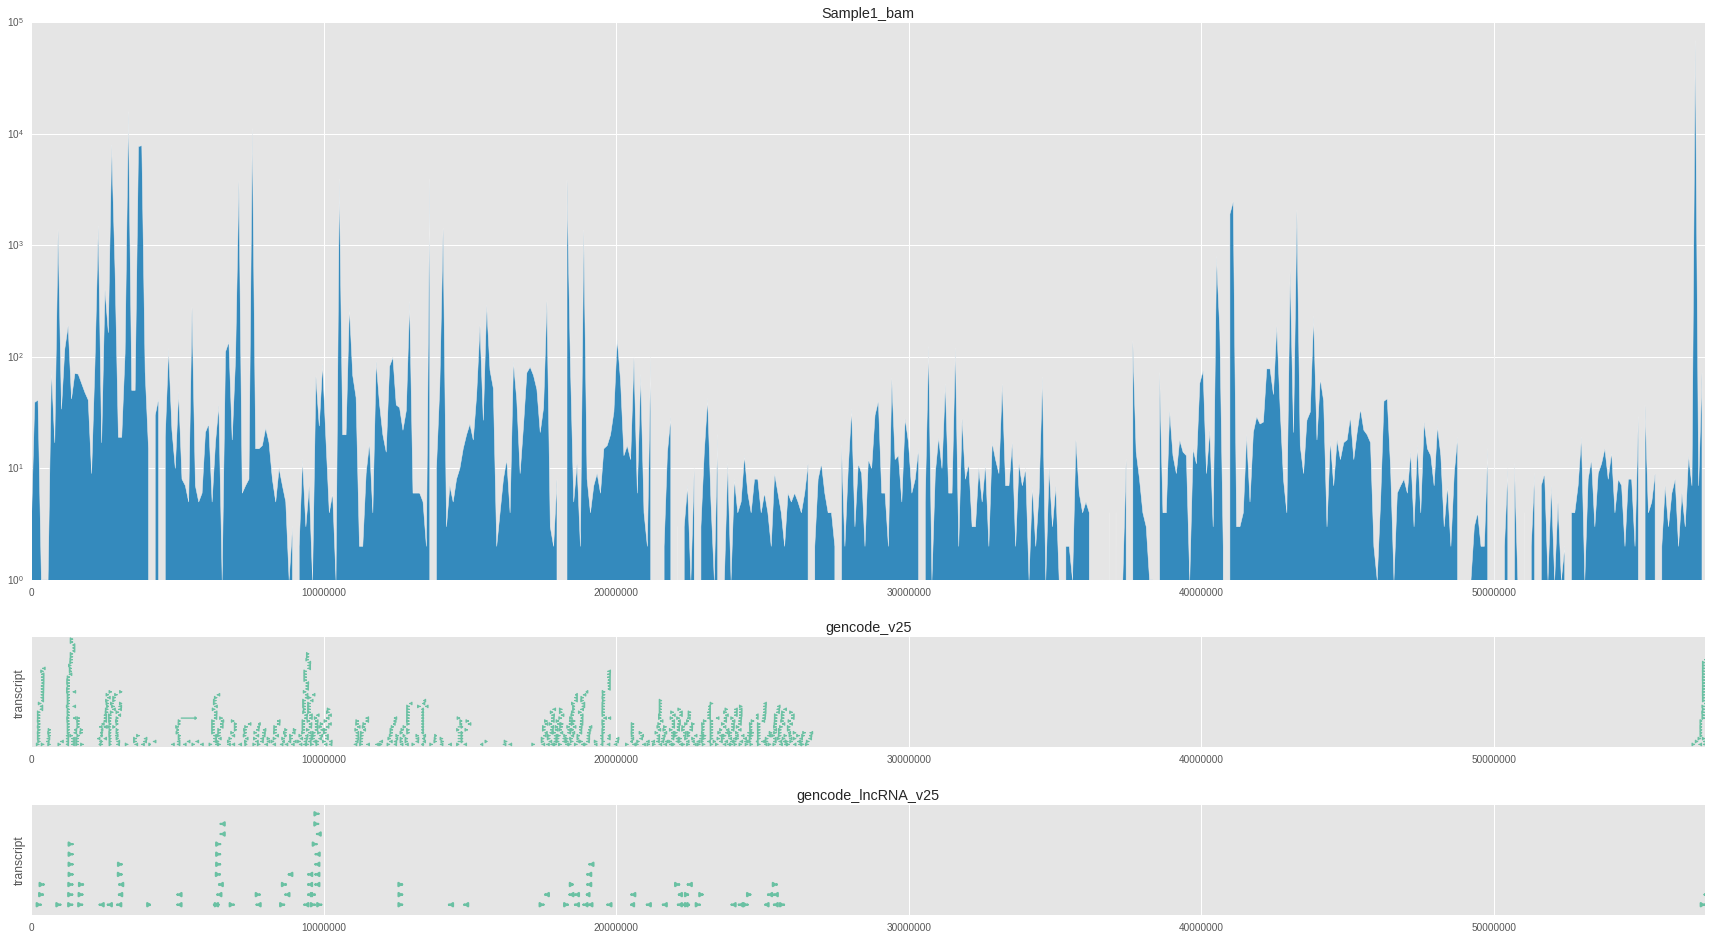

In [7]:
a.plot_interval("chrY", annotation_feature_types=["transcript"], alignment_yscale="log")

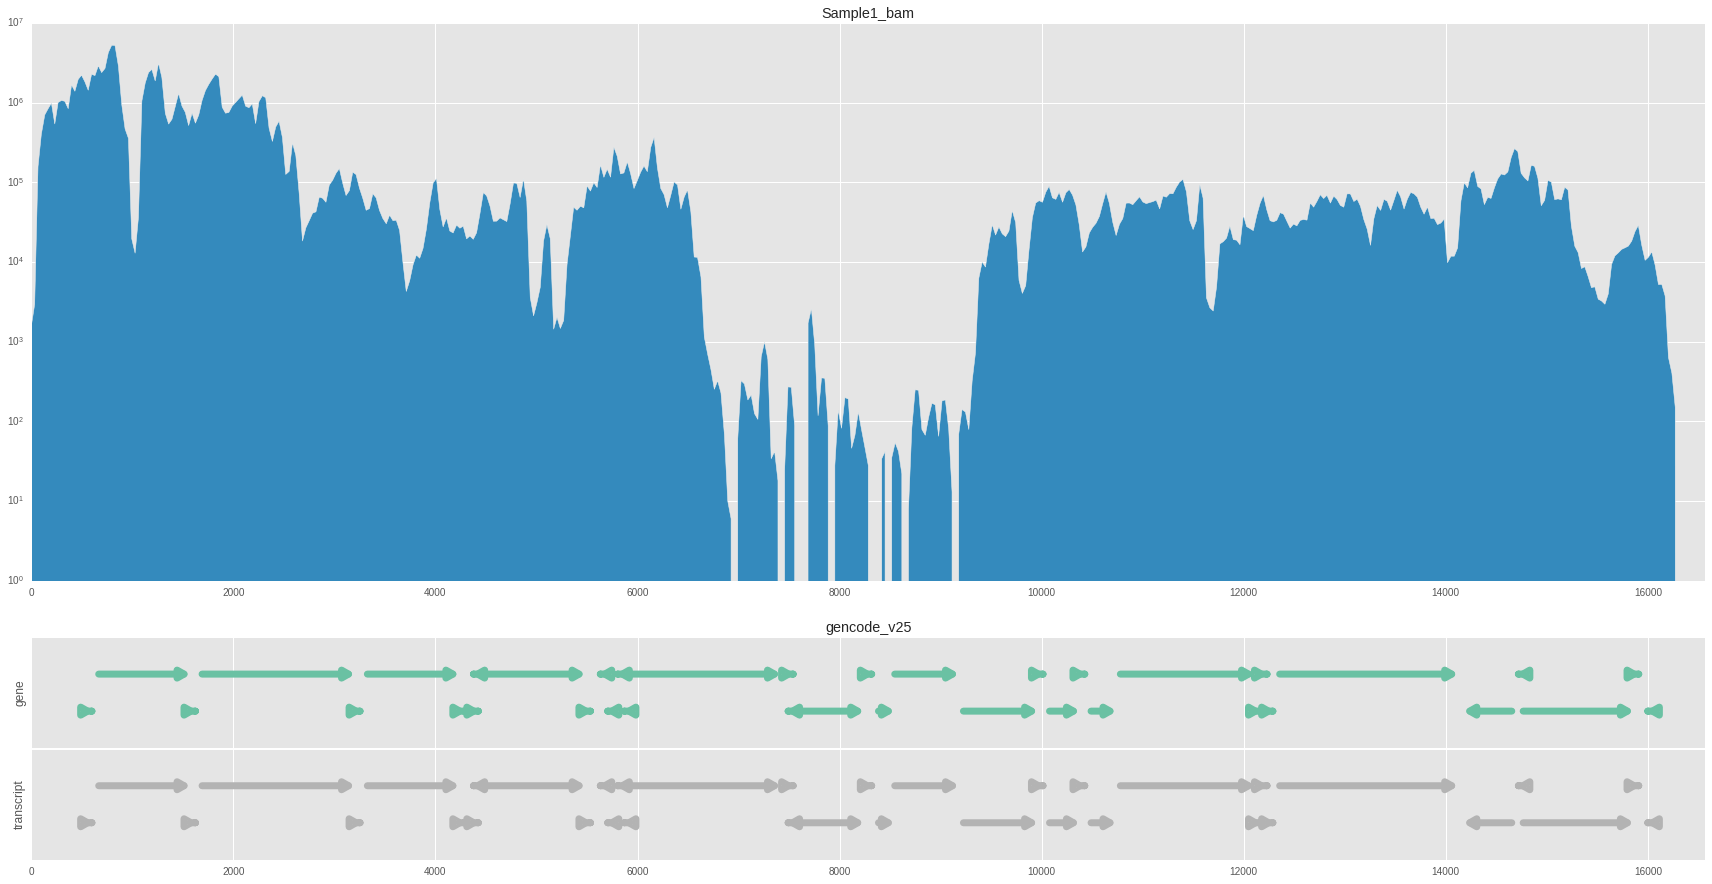

In [8]:
a.plot_interval("chrM", annotation_feature_types=["transcript", "gene"], alignment_yscale="log", annotation_tracks=["gencode_v25"])

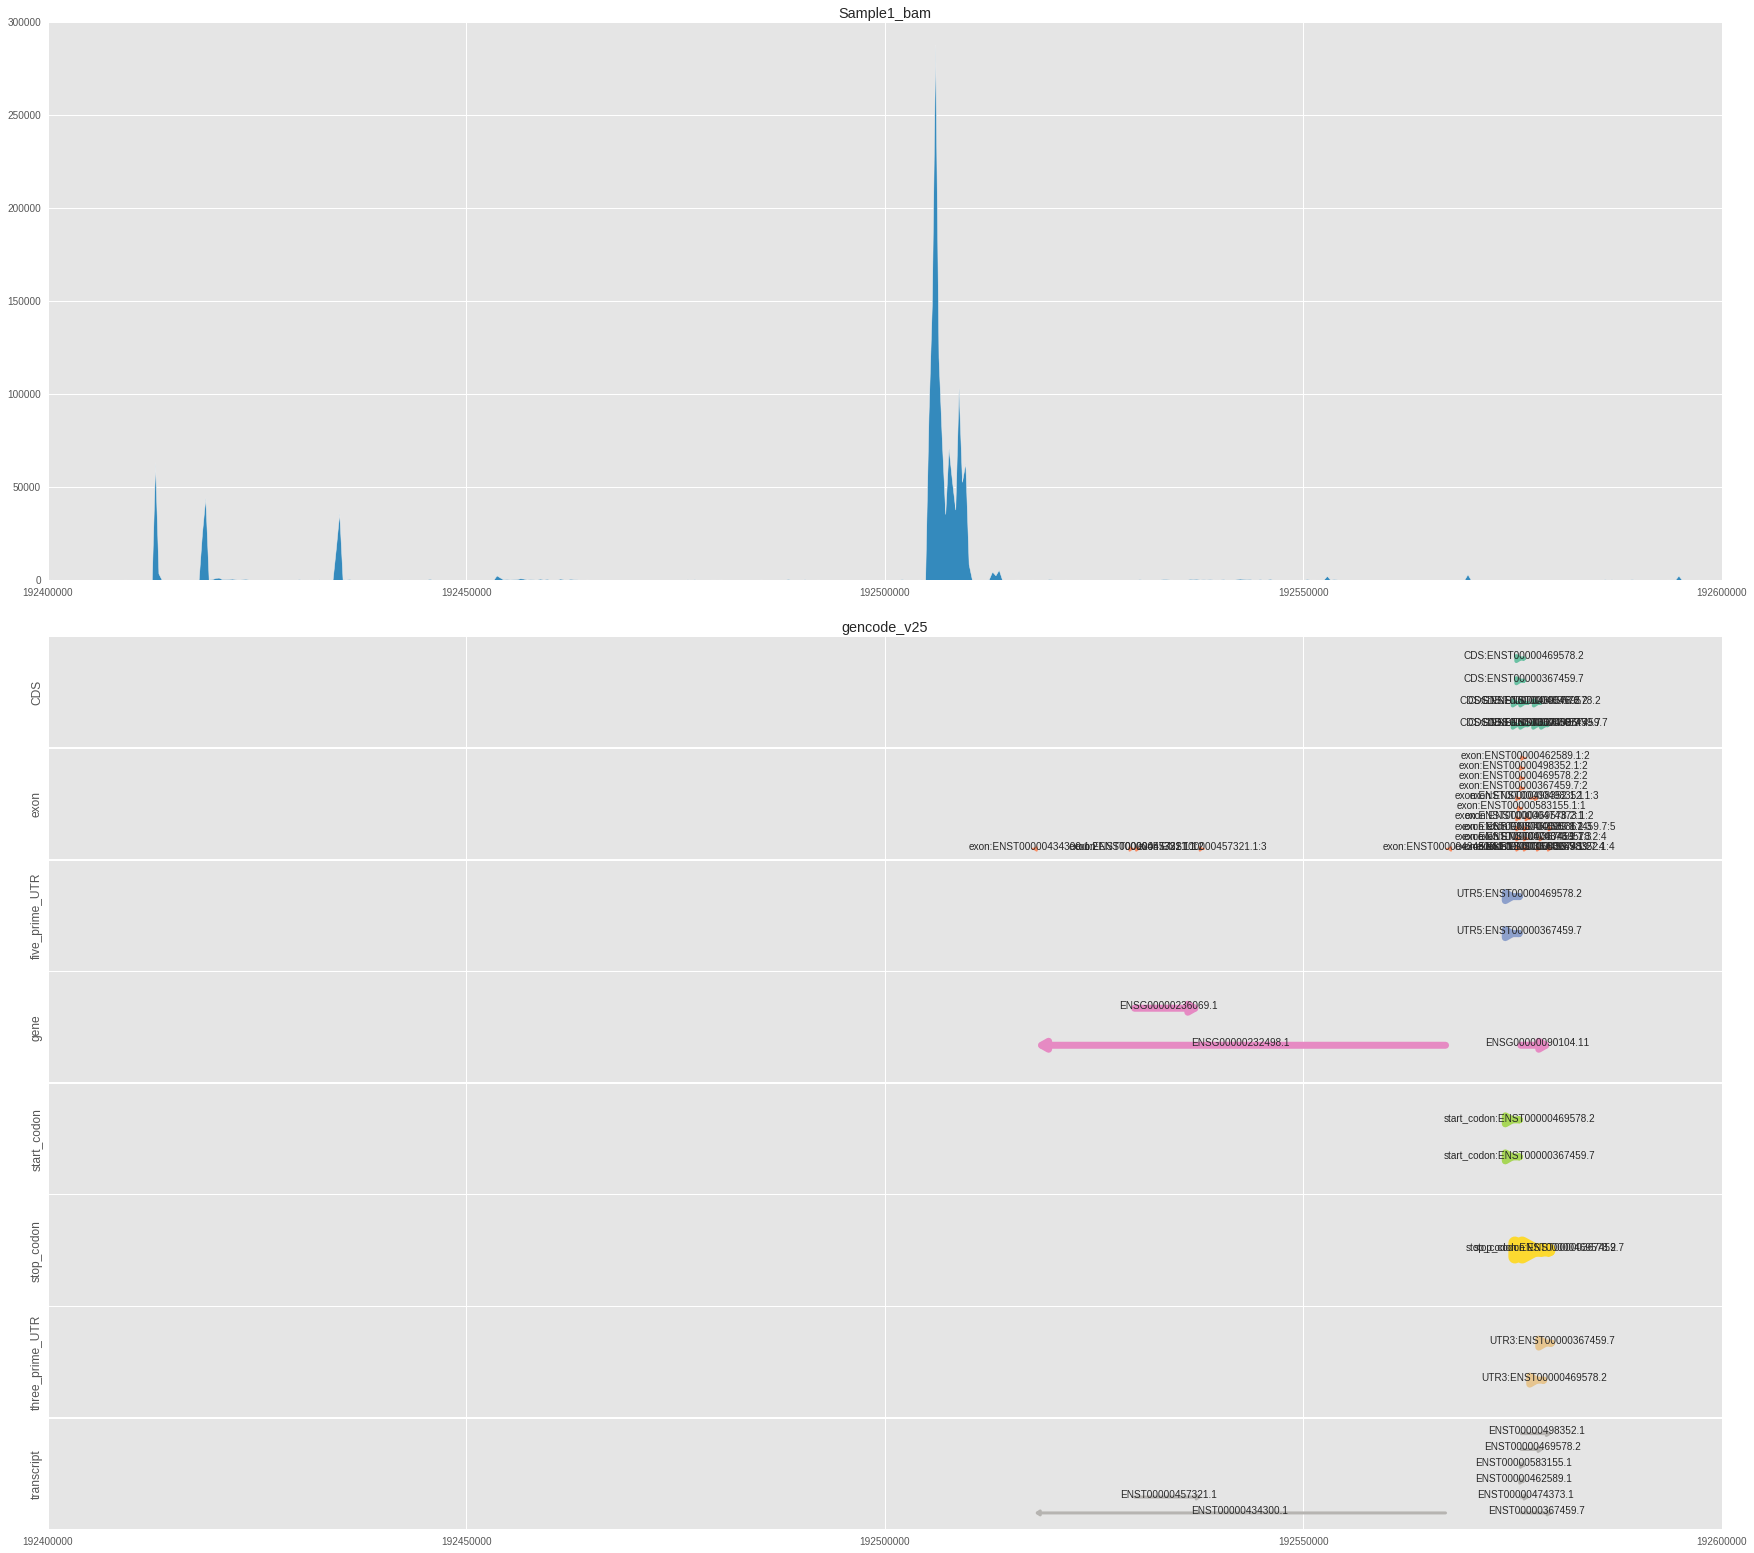

In [20]:
a.plot_interval("chr1", start=192400000, end=192600000, alignment_yscale="linear", annotation_tracks=["gencode_v25"], annotation_label=True)

In [221]:
def sliding_window_list (start=0, end=1000, n_sliding_windows=200, plot=False, plot_style="ggplot"):
    """
    slide window overlap of 50%
    """
    
    # Compute the size of overlapping windows 
    bin_size = (end-start)/(n_sliding_windows+1)*2
    
    # Ploting only option
    if plot:
        pl.style.use(plot_style)
        figure, subplot = pl.subplots(figsize=(30, 5), frameon=False)
        subplot.set_xlim((start, end))
        subplot.set_ylim((0, n_sliding_windows+1))
        for i in range(n_sliding_windows):
            subplot.add_patch(arrow (posA=[start,i+1], posB=[start+bin_size,i+1],
                              linewidth=12/n_sliding_windows+1, edgecolor="black", facecolor="black"))
            start+=bin_size/2
    
    # listing only option
    else:
        windows_list=[]
        for i in range(n_sliding_windows):
            windows_list.append([start, start+bin_size])
            start+=bin_size/2
        return (windows_list)

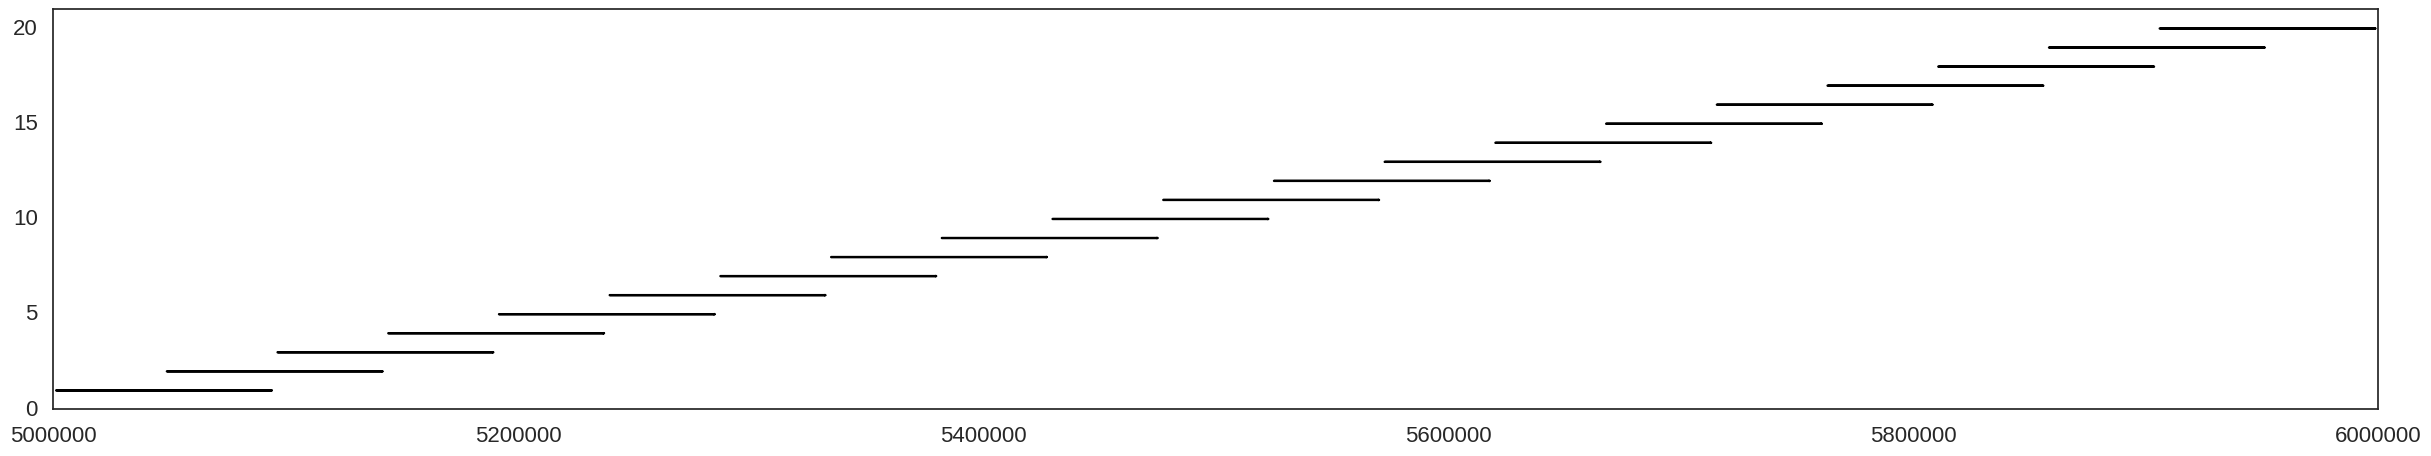

In [244]:
sliding_window_list(5000000, 6000000, 20, True, "seaborn-white")

In [144]:
sliding_window_list(10000, 20000, 20, False)

[[10000, 10952.380952380952],
 [10476.190476190477, 11428.57142857143],
 [10952.380952380954, 11904.761904761906],
 [11428.571428571431, 12380.952380952383],
 [11904.761904761908, 12857.14285714286],
 [12380.952380952385, 13333.333333333338],
 [12857.142857142862, 13809.523809523815],
 [13333.33333333334, 14285.714285714292],
 [13809.523809523816, 14761.904761904769],
 [14285.714285714294, 15238.095238095246],
 [14761.90476190477, 15714.285714285723],
 [15238.095238095248, 16190.4761904762],
 [15714.285714285725, 16666.66666666668],
 [16190.476190476202, 17142.857142857156],
 [16666.66666666668, 17619.047619047633],
 [17142.857142857156, 18095.23809523811],
 [17619.047619047633, 18571.428571428587],
 [18095.23809523811, 19047.619047619064],
 [18571.428571428587, 19523.80952380954],
 [19047.619047619064, 20000.00000000002]]

In [58]:
def plot_alignment (fp, seqid, start=0, end=100000, n_step=500, yscale="linear", plot_style="ggplot", force_mode=None, track_height=10, track_width=30):
    """
    * force_mode None or "read_count" or "base_coverage"
    """
    x = []
    y = []
    len_range = end-start
    step_size = (end-start) / float(n_step)
    
    # Count method is less accurate but much quicker for very long intervals.
    # Do not take into account spliced sites, ie read will be represented from their first mapped
    # to their last base
    if force_mode == "read_count" or (not force_mode and len_range > 5000000):
        start_pos = start
        with pysam.AlignmentFile(fp) as bam:
            for i in range(n_step):
                
                x.append(start_pos+step_size/2)
                y.append(bam.count(seqid, start_pos, start_pos+step_size))
                
                start_pos+=step_size
    
    # Coverage method is more precise and quicker for smaller intervals but become really slow when > 5000000
    elif force_mode == "base_coverage" or (not force_mode and len_range <= 5000000):
        with pysam.AlignmentFile(fp) as bam:
            mat = bam.count_coverage(seqid, start, end)
            start_pos = 0
            while start_pos <= len_range-step_size:            
                s = round(start_pos)
                e = round(start_pos+step_size)
                
                x.append(start+start_pos)
                y.append(sum(mat[0][s:e])+sum(mat[1][s:e])+sum(mat[2][s:e])+sum(mat[3][s:e]))
                
                start_pos+=step_size
                
    pl.style.use(plot_style)
    figure, subplot = pl.subplots(figsize=(track_width, track_height))
    subplot.set_xlim((start, end))
    
    if yscale == "log":
        if any(y) <= 0:
            warnings.warn("Data has no positive values, and therefore can not be log-scaled.")
        else:
            subplot.set_yscale("log")
    
    subplot.fill_between(x, 0, y)

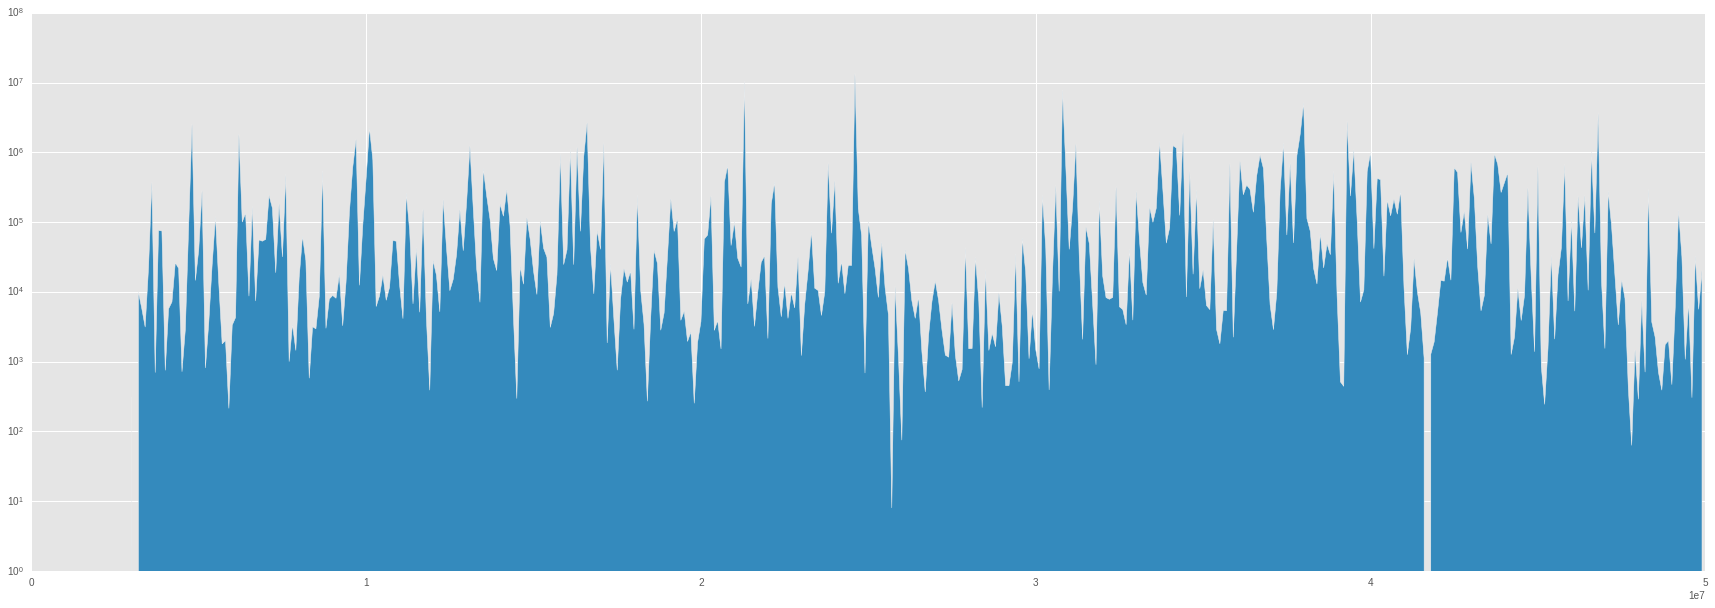

In [61]:
b = "./test_data/out.bam"
plot_alignment(fp=b, seqid="chr1", start=0, end=50000000, n_step=500, yscale="log", force_mode="base_coverage")

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Container object of 9 artists>

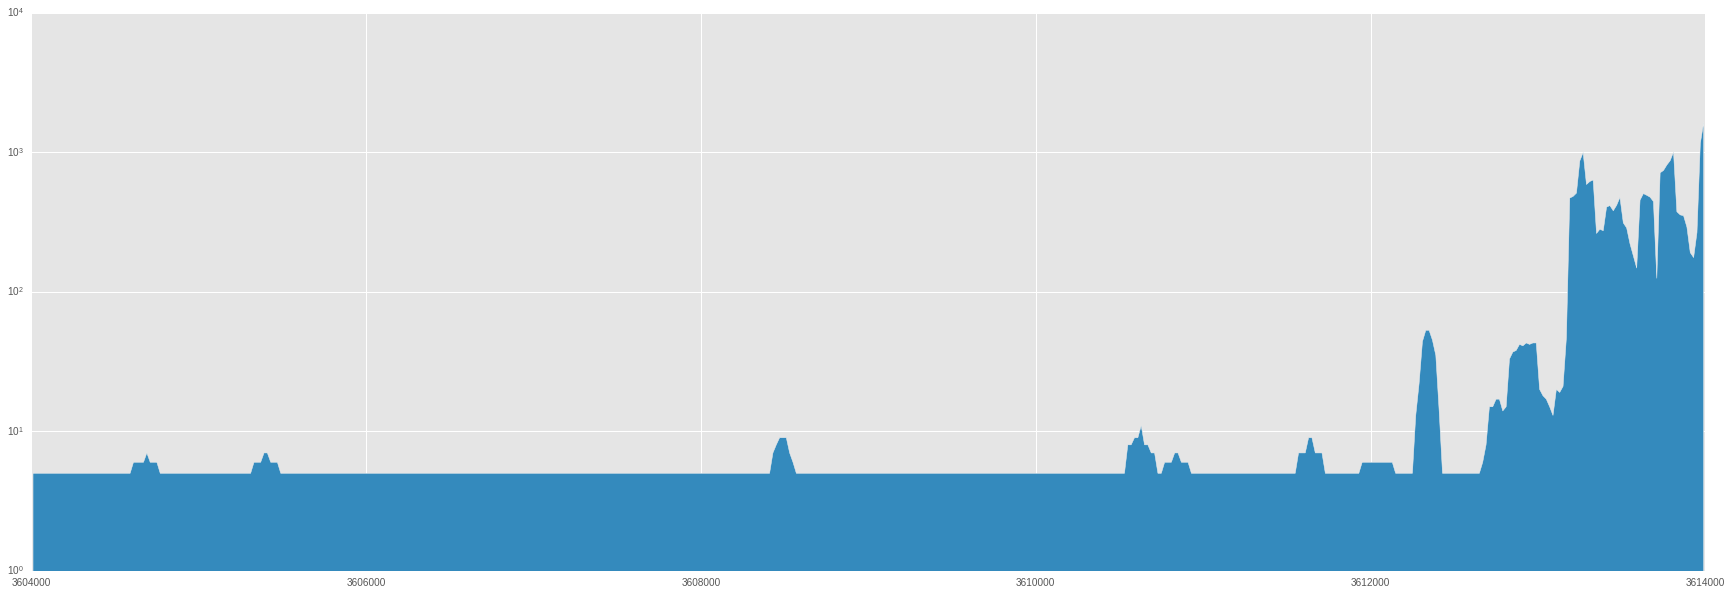

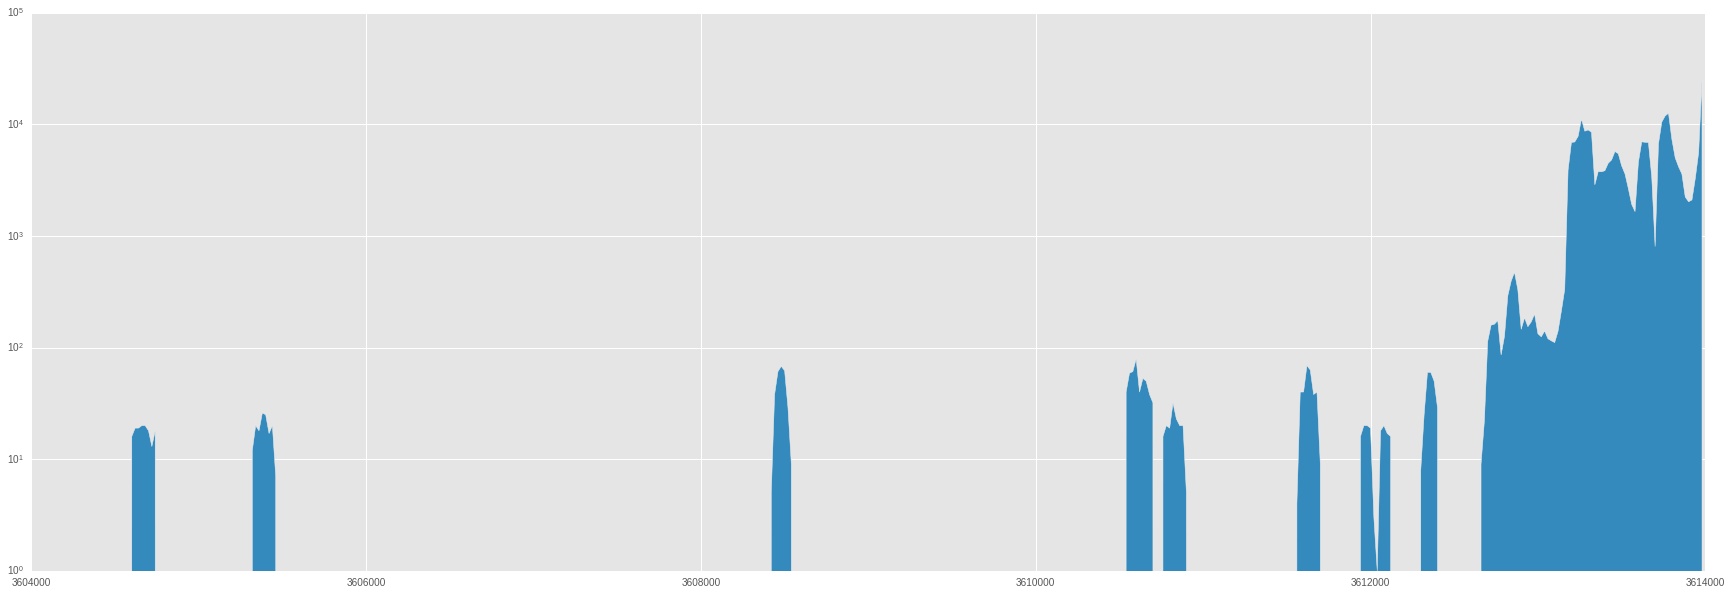

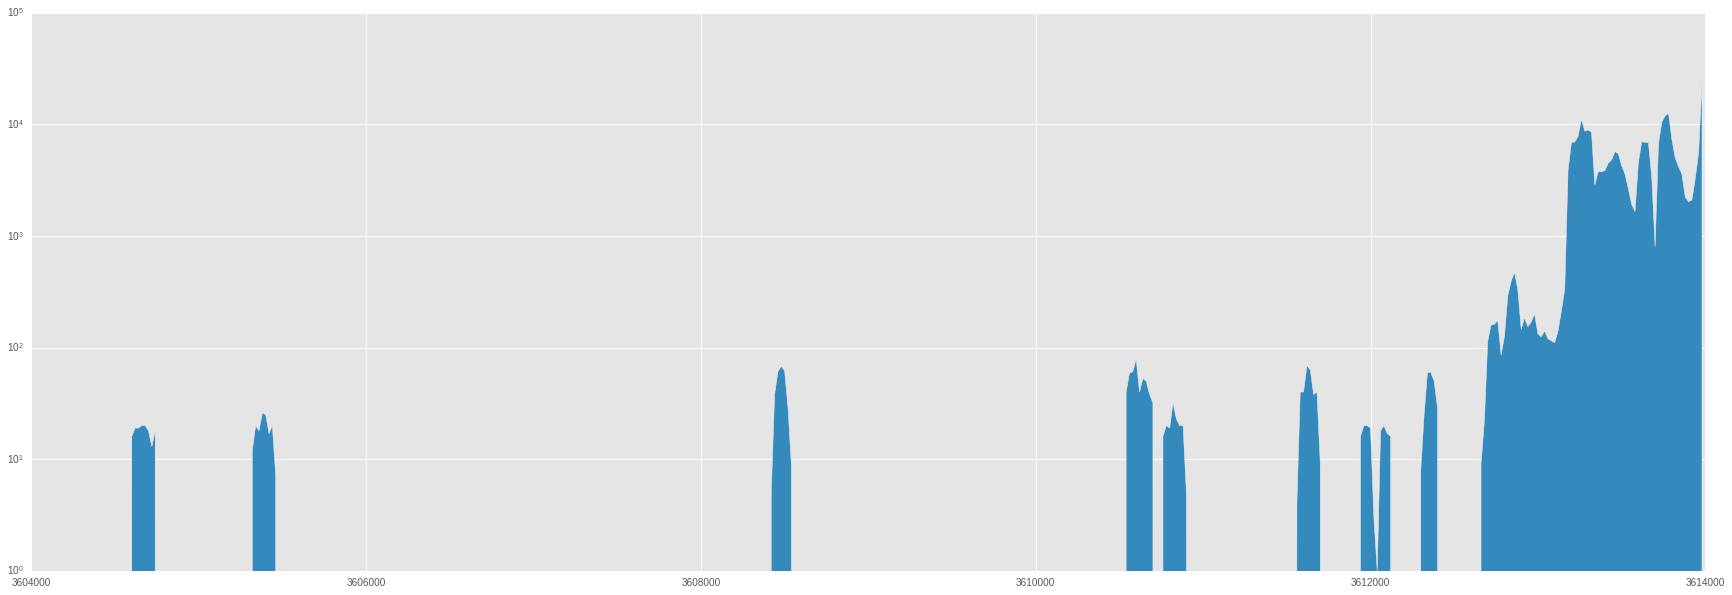

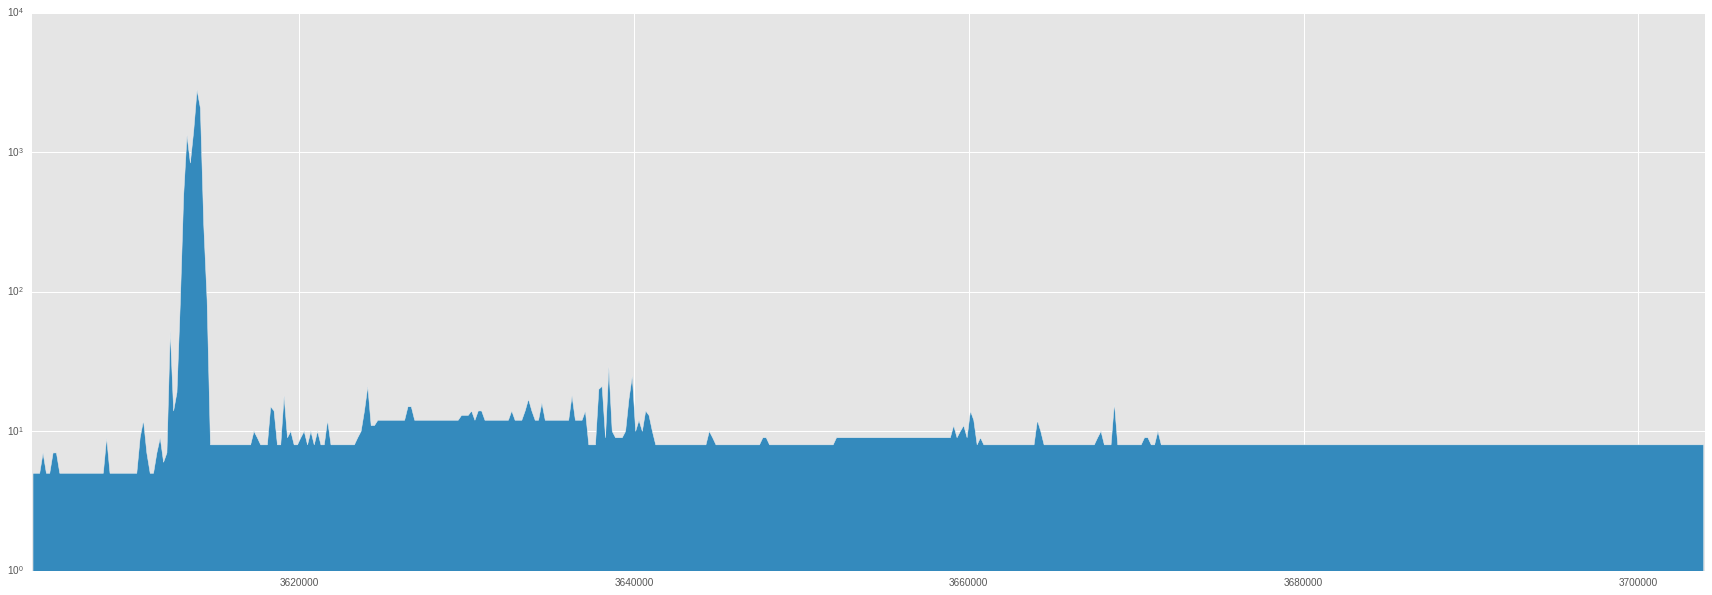

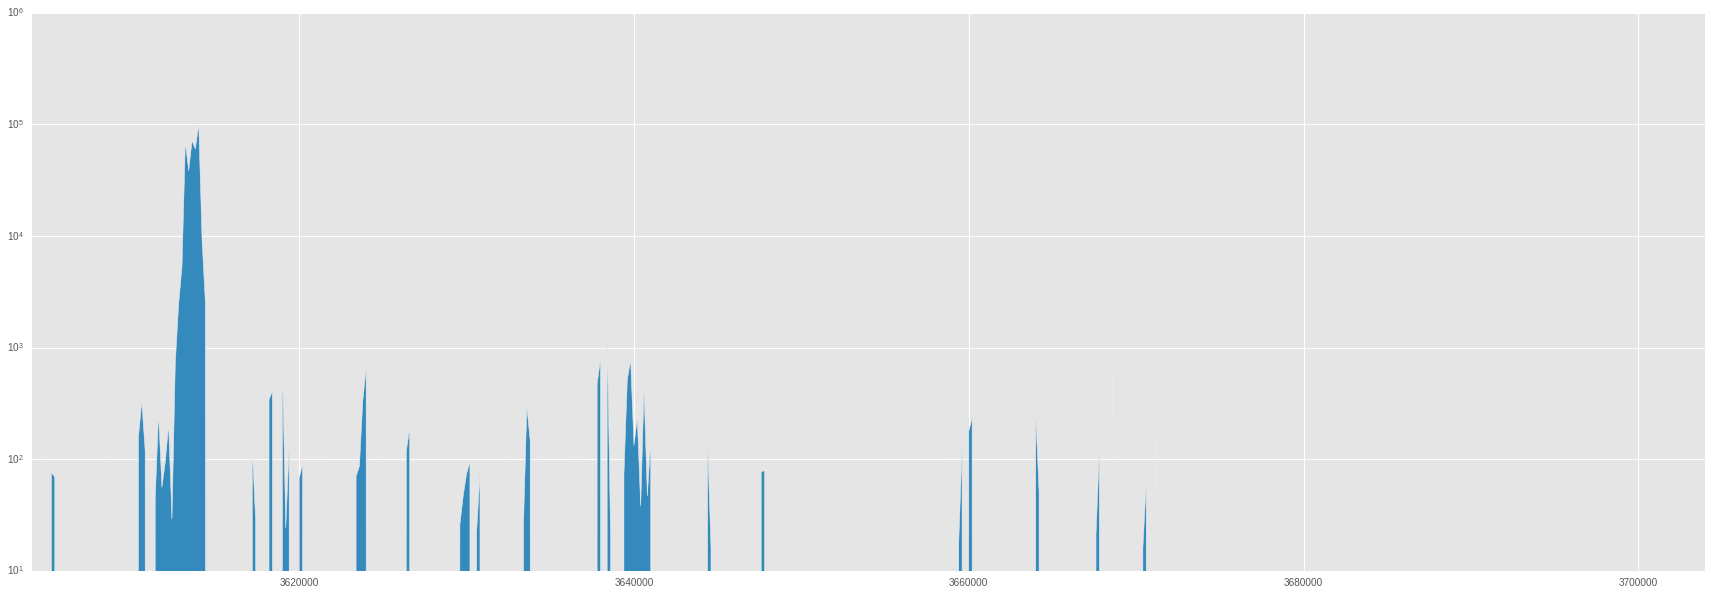

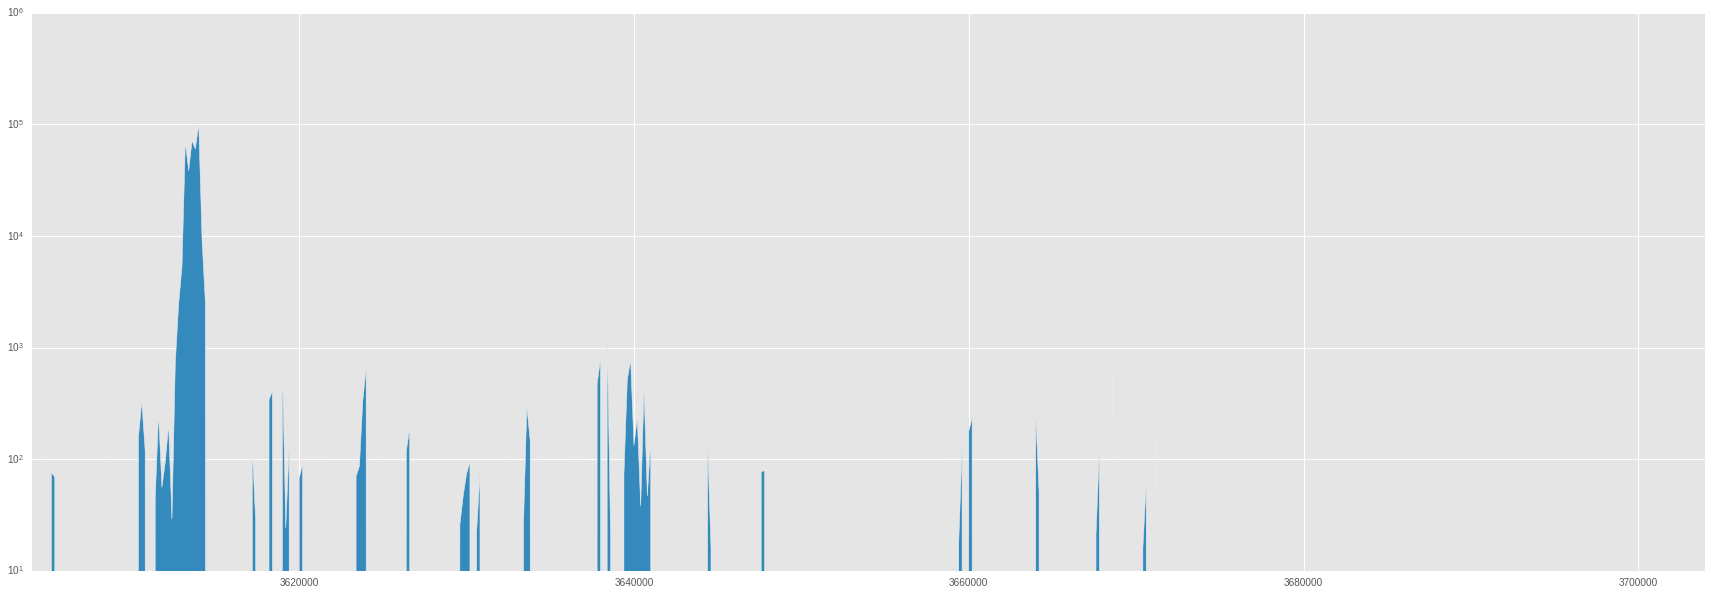

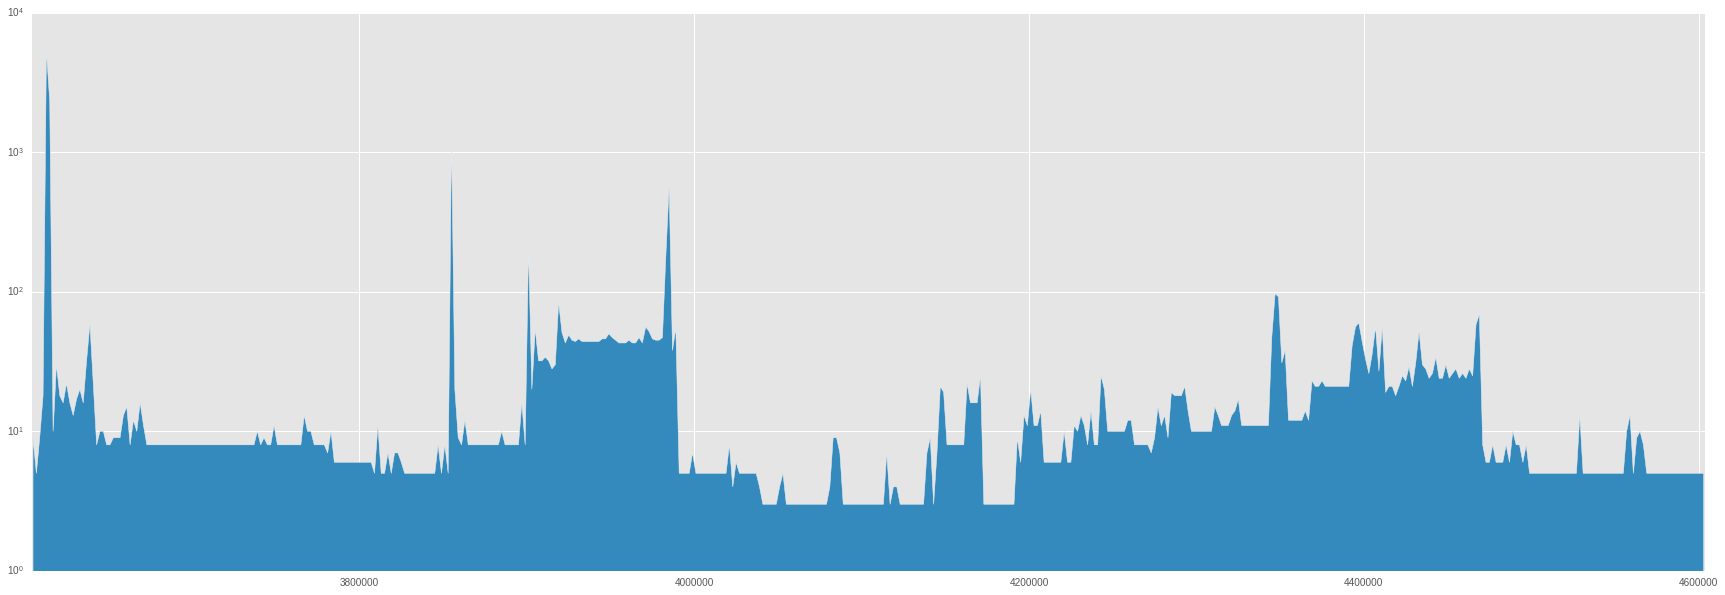

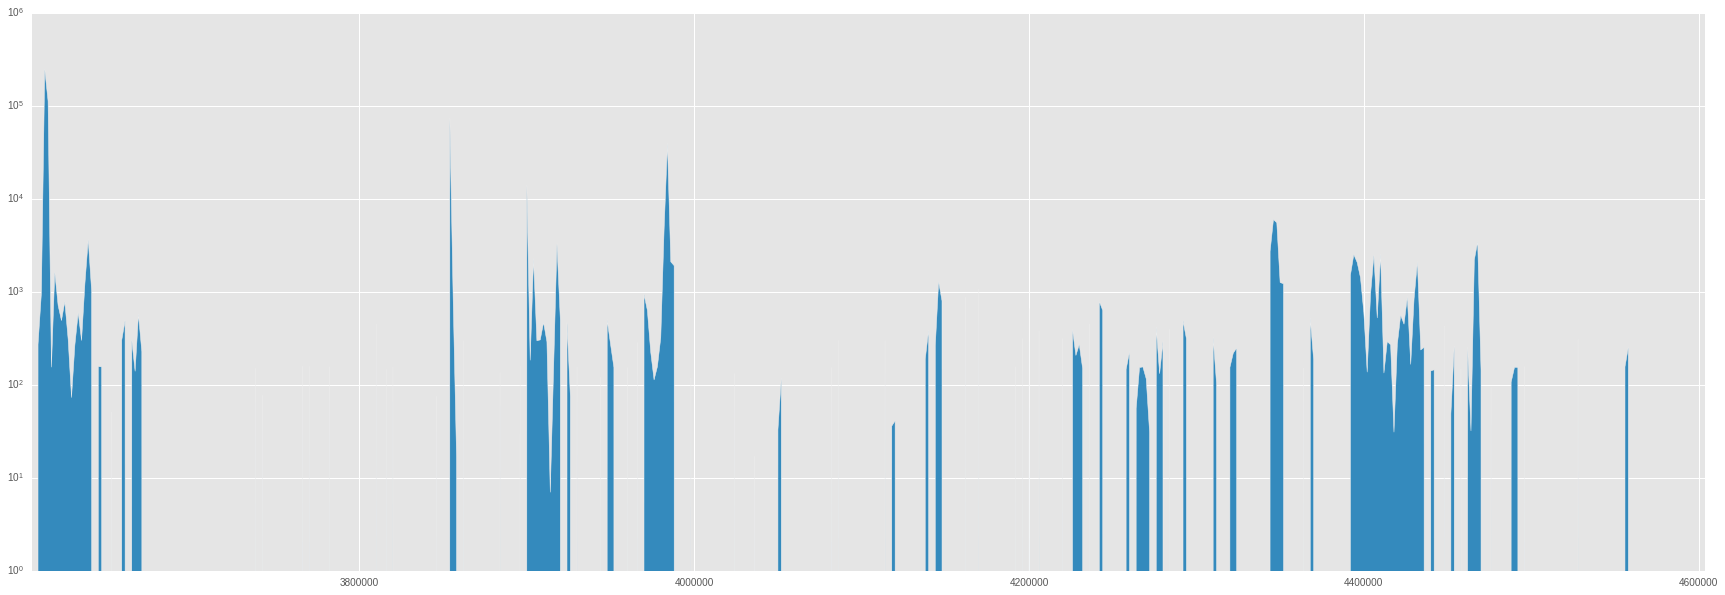

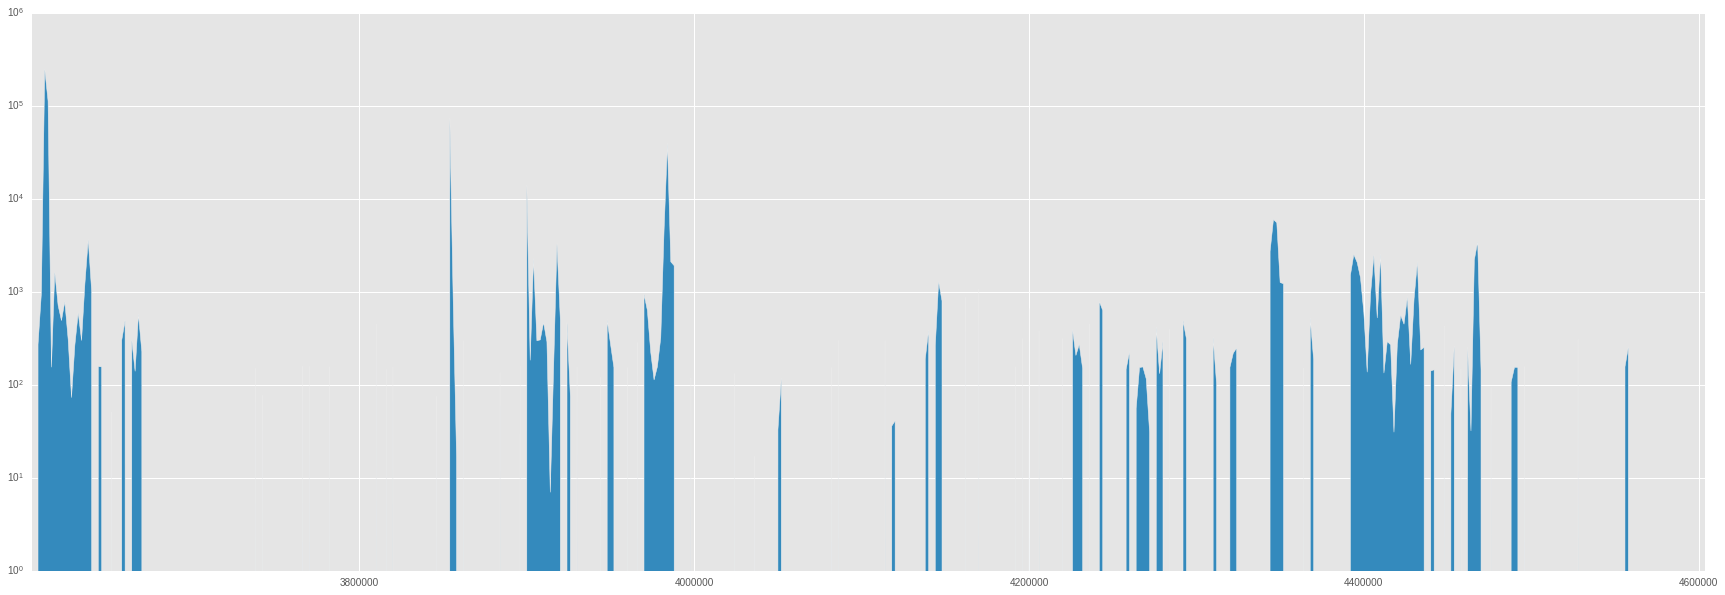

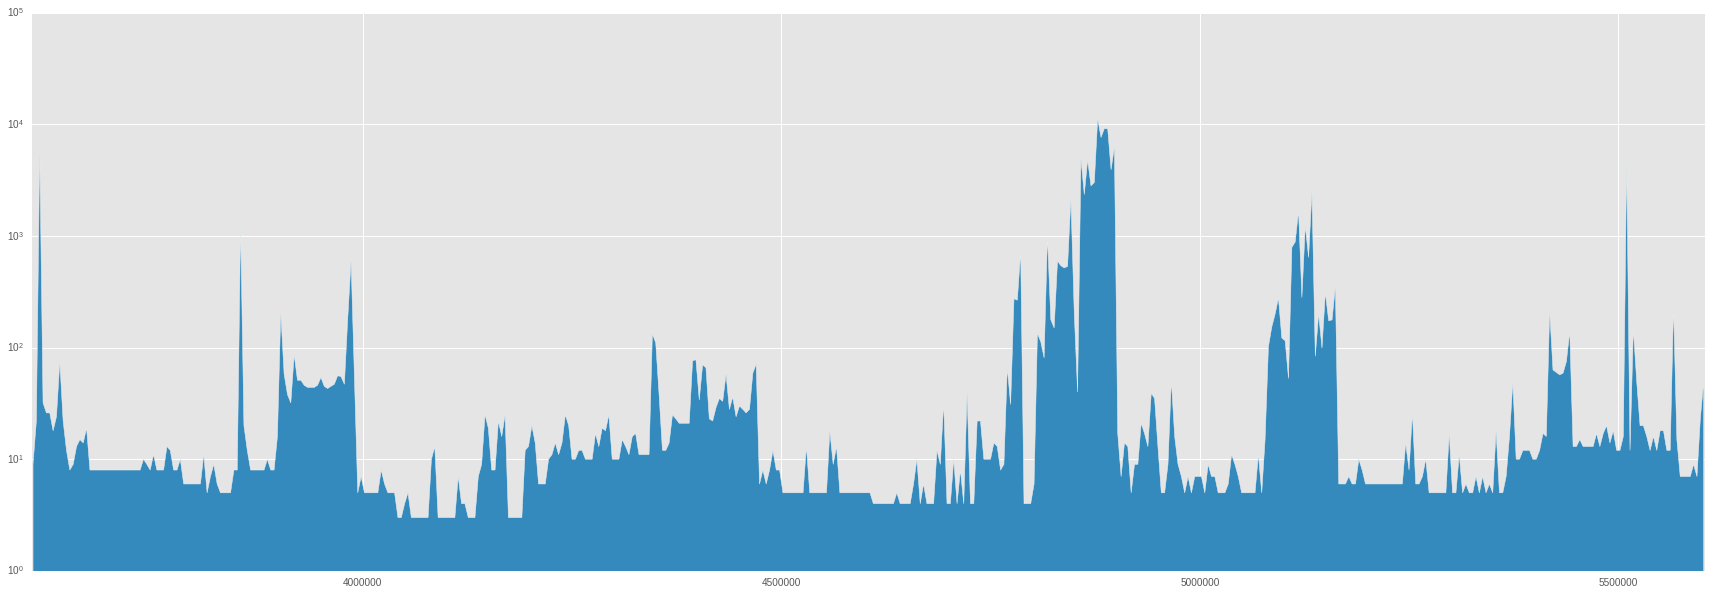

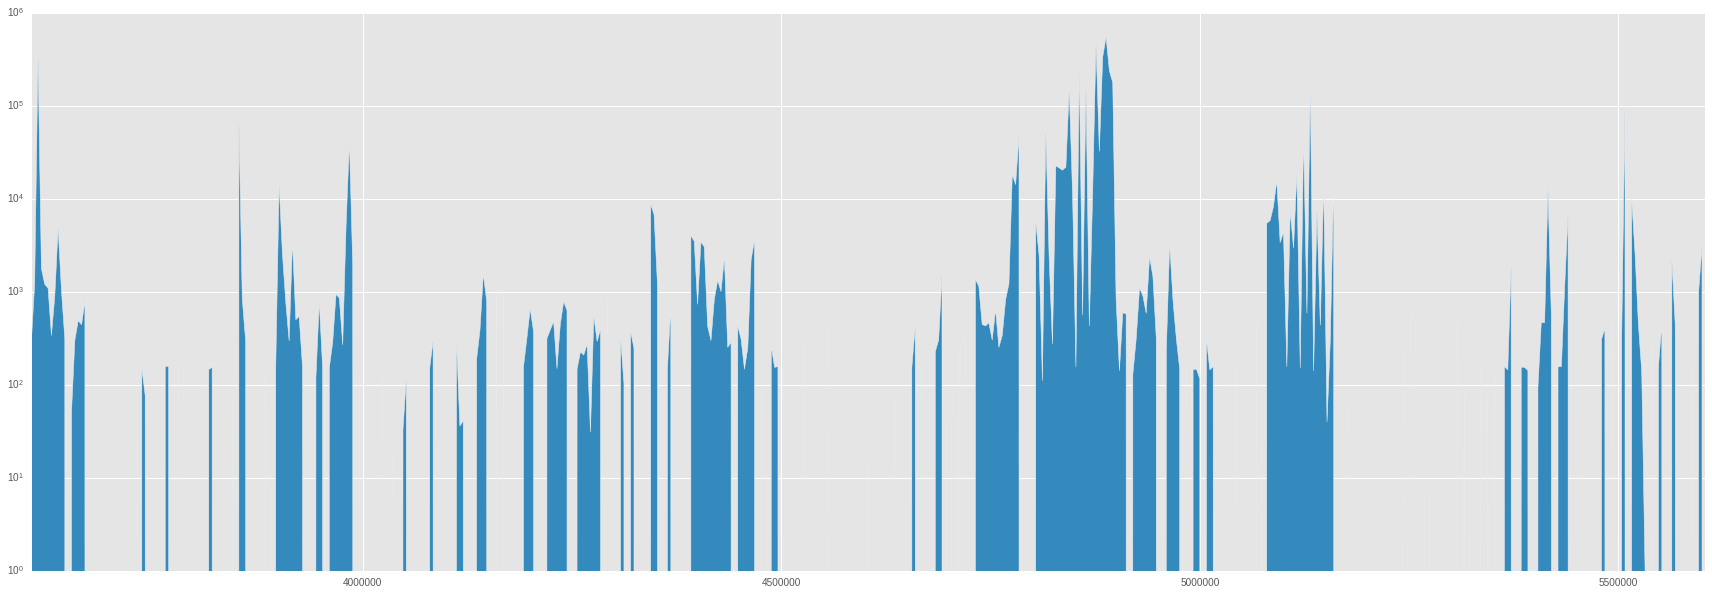

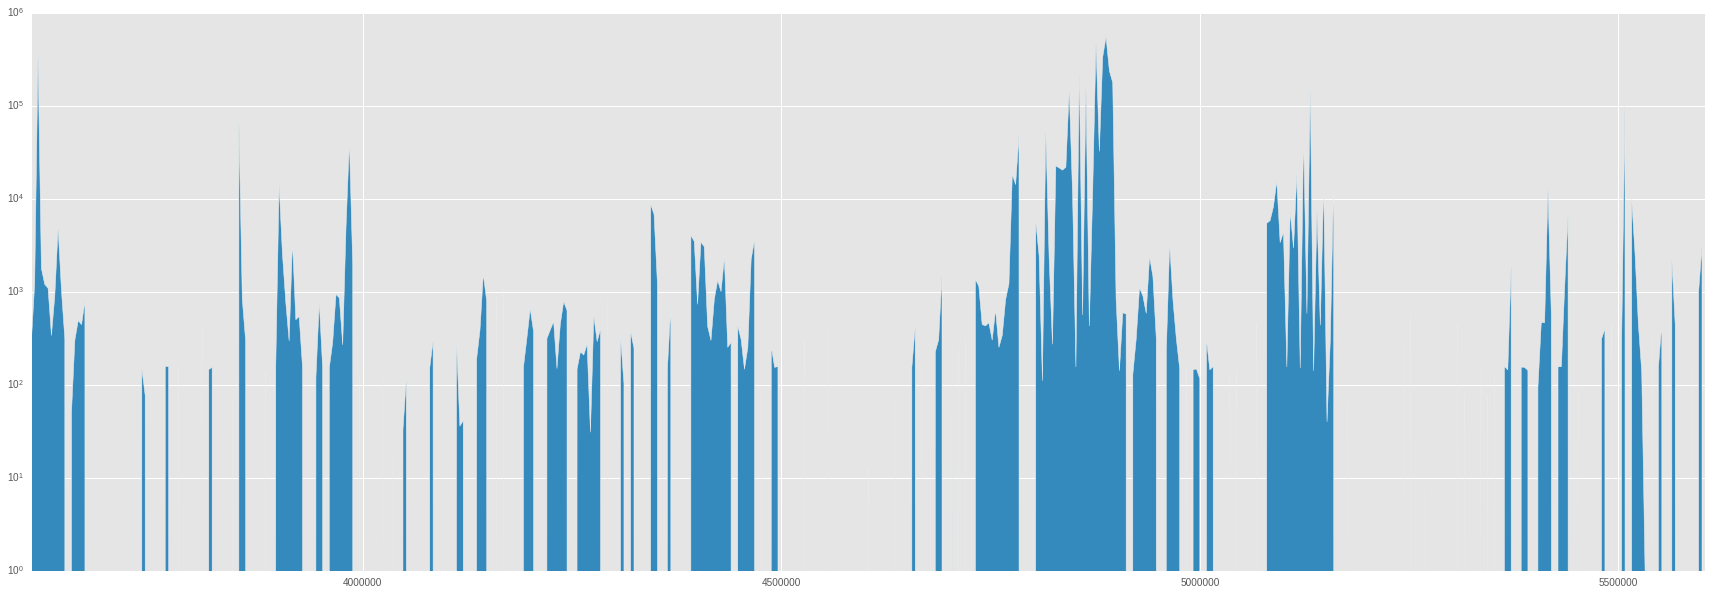

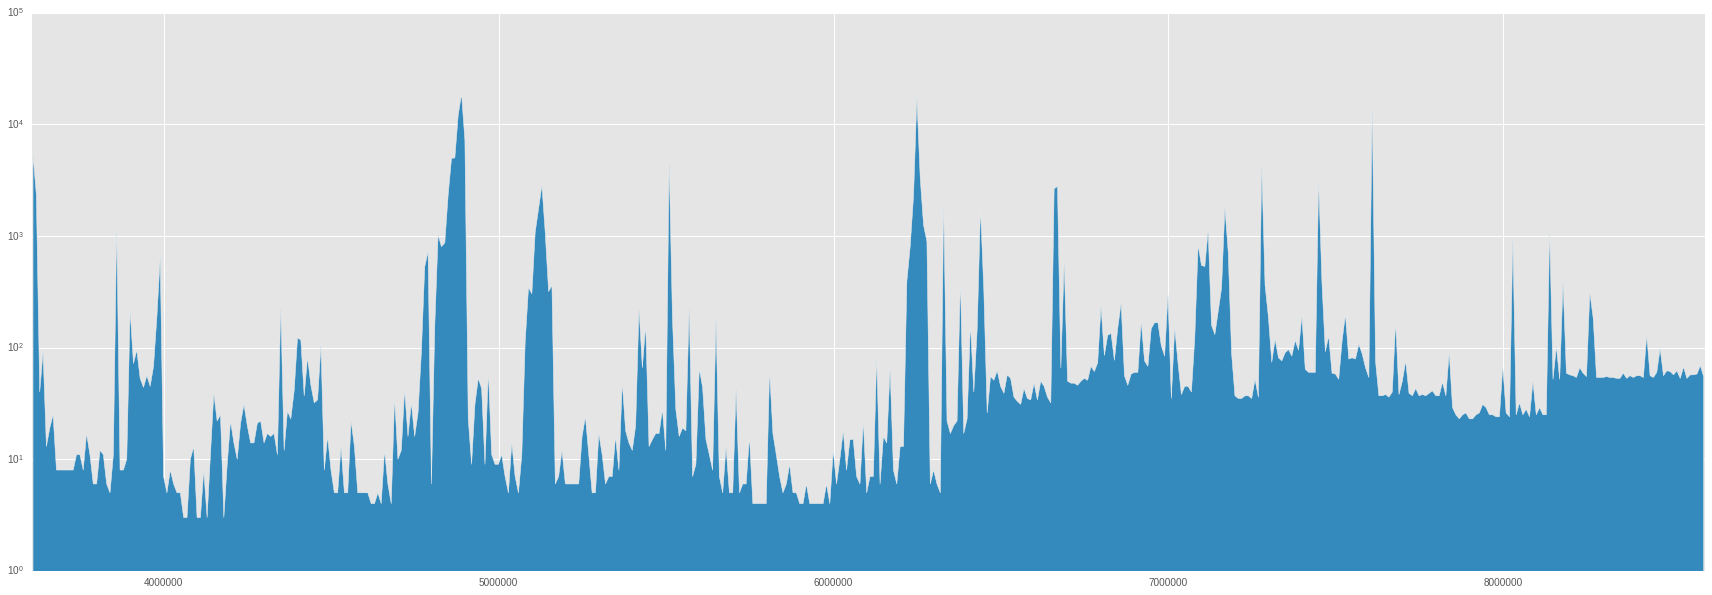

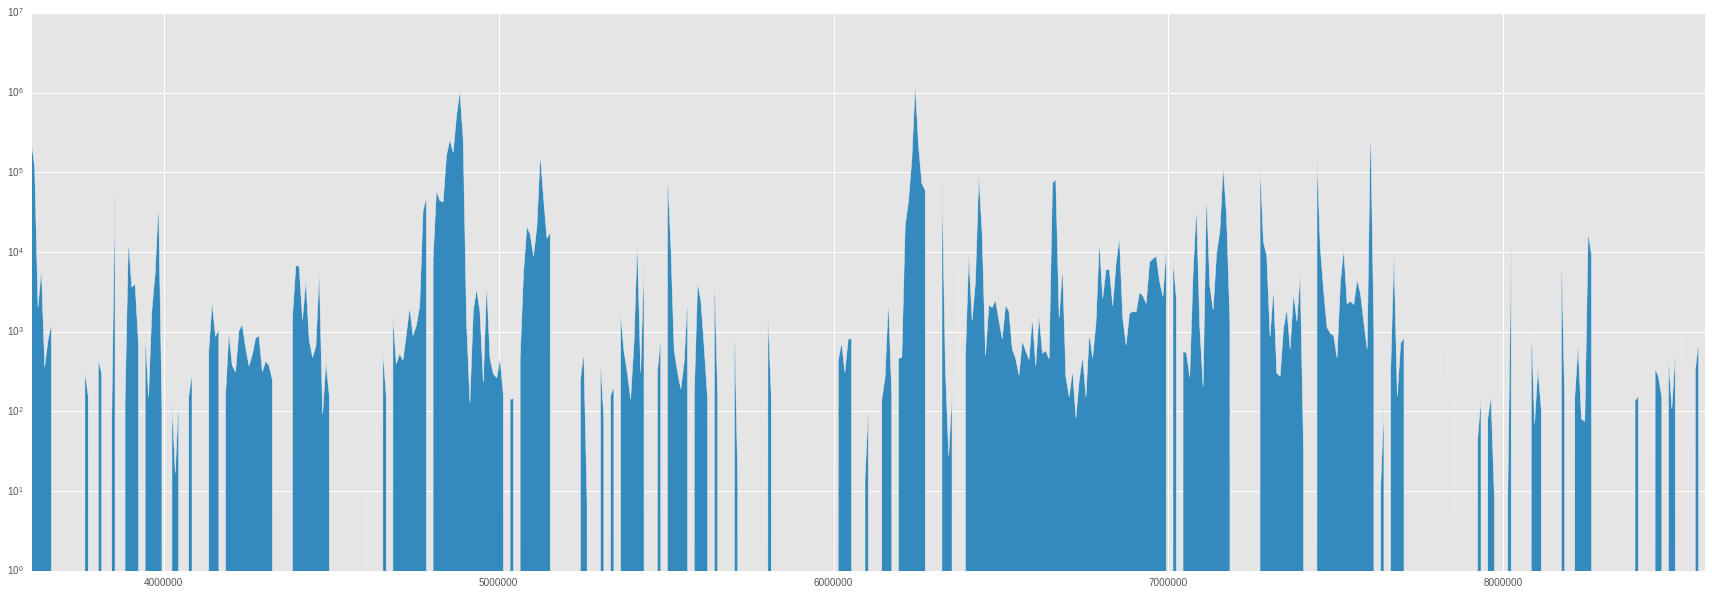

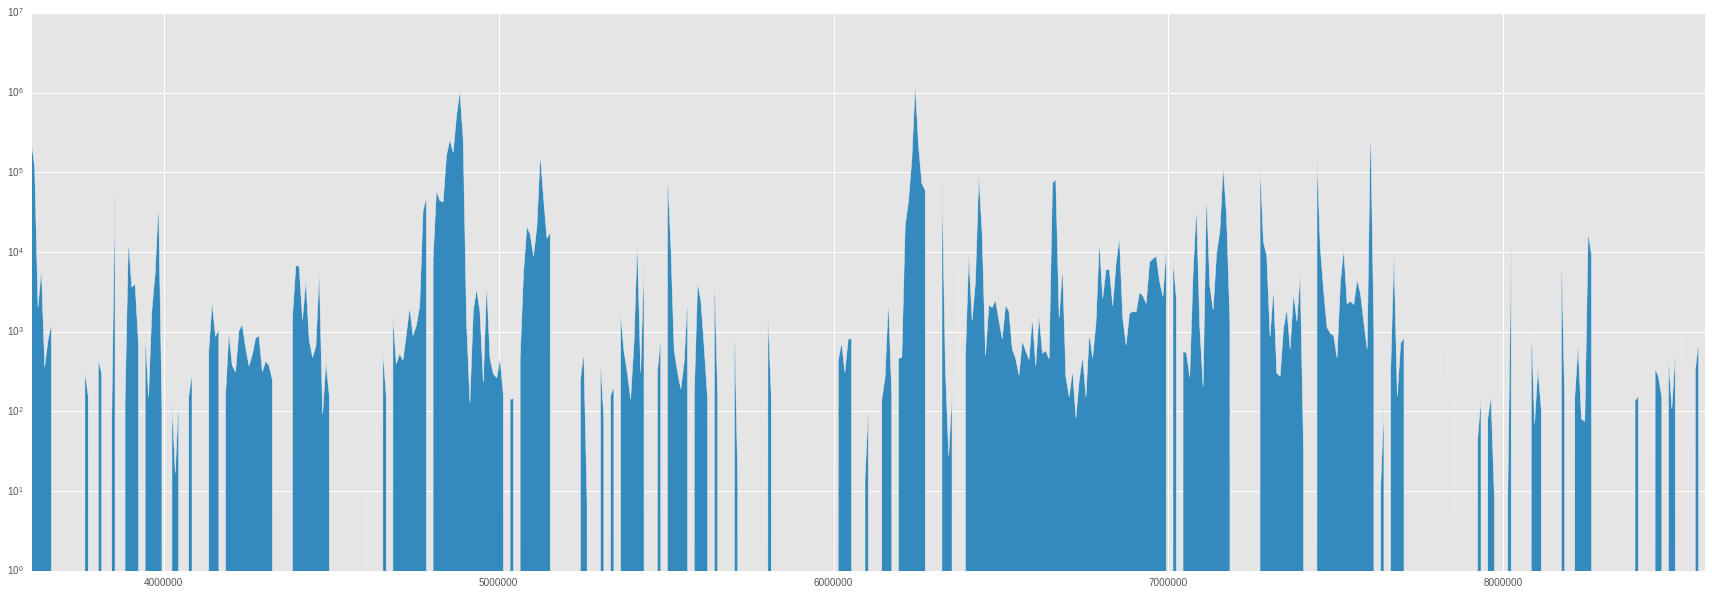

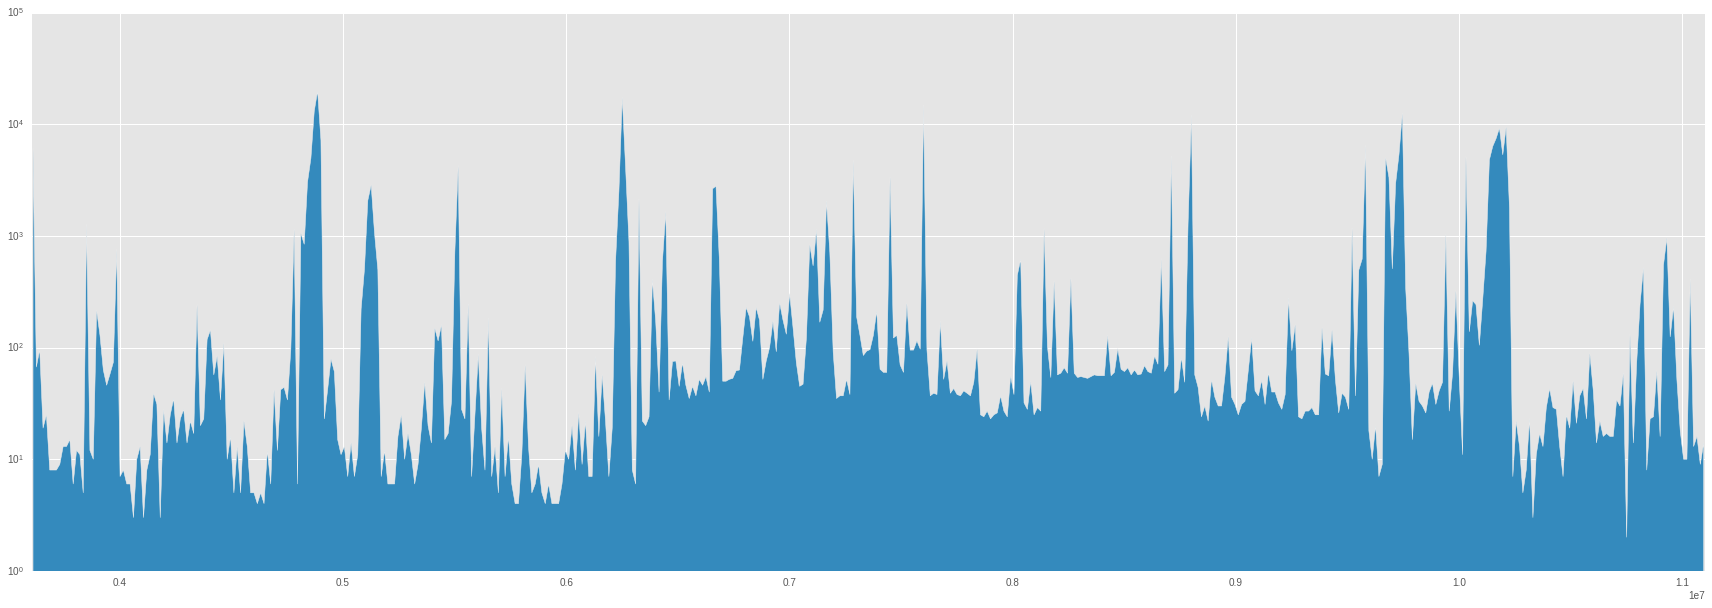

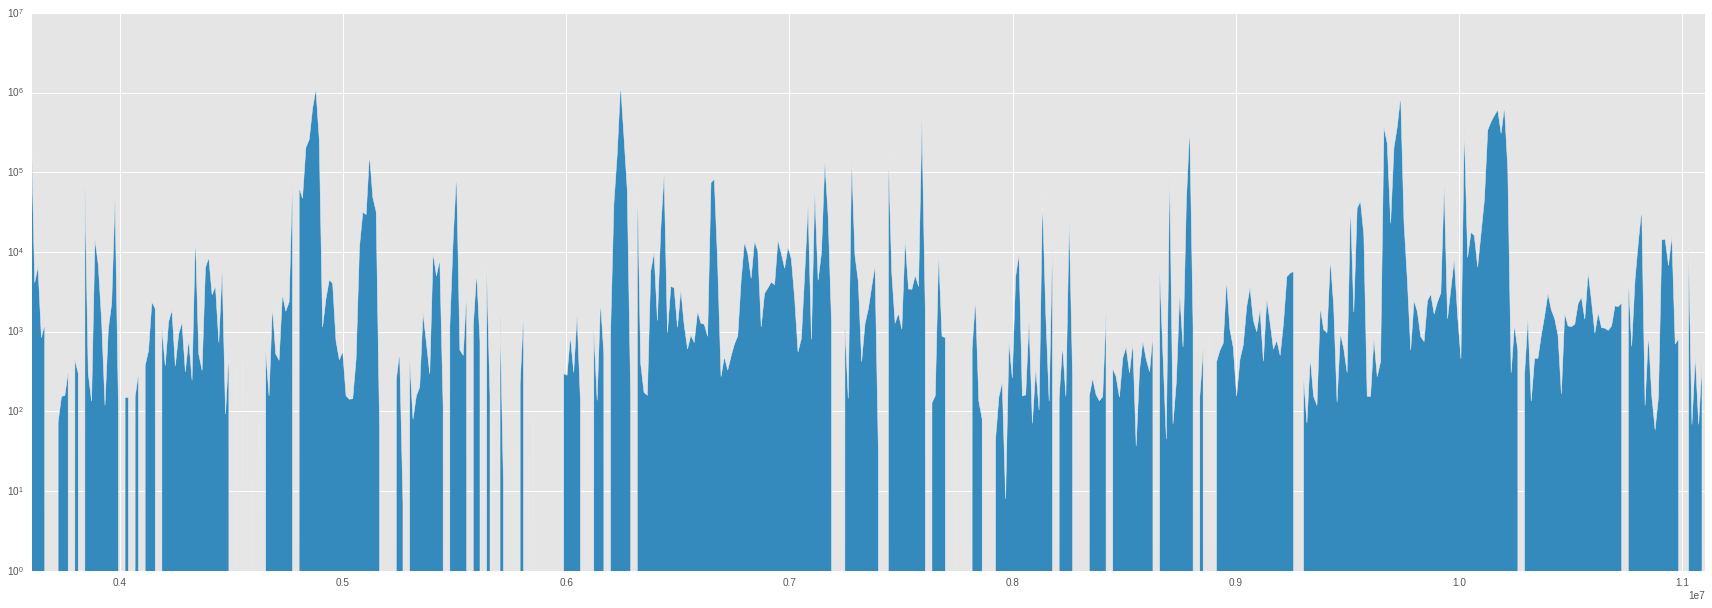

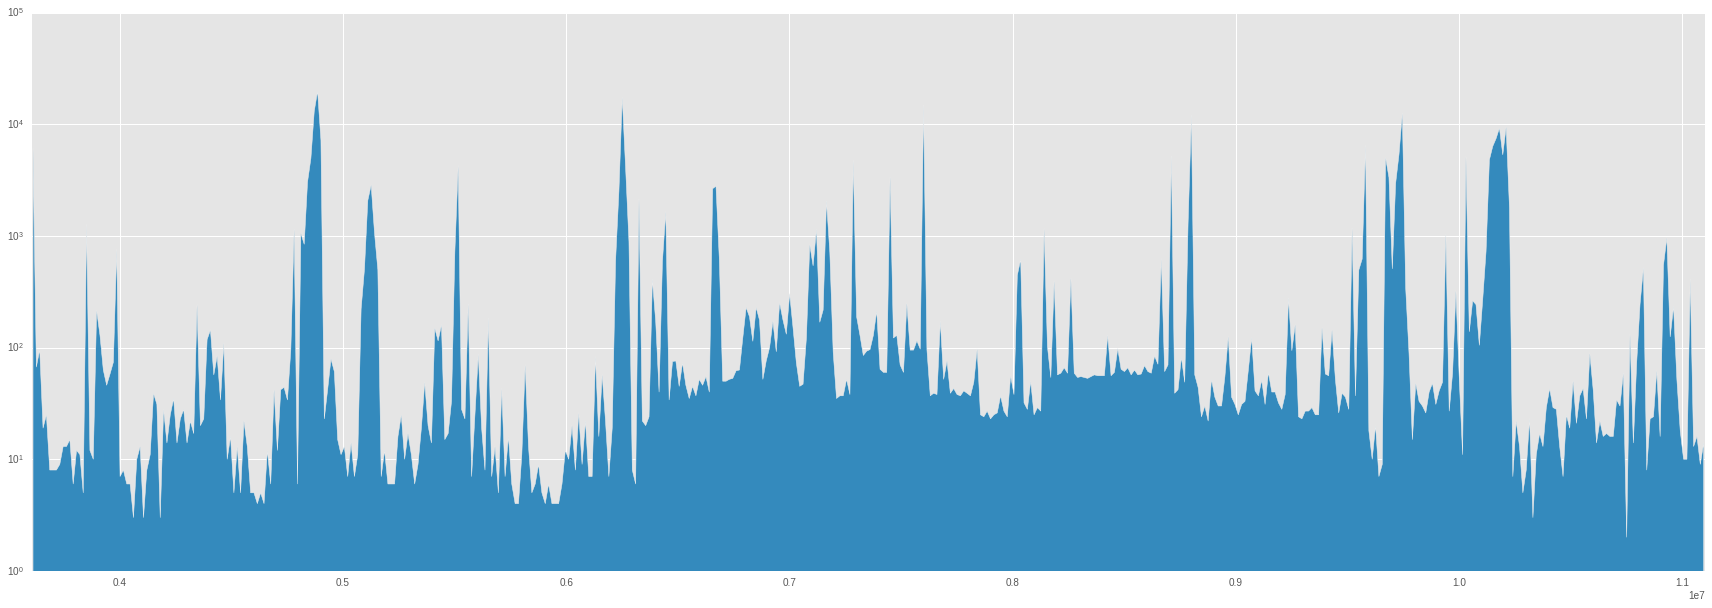

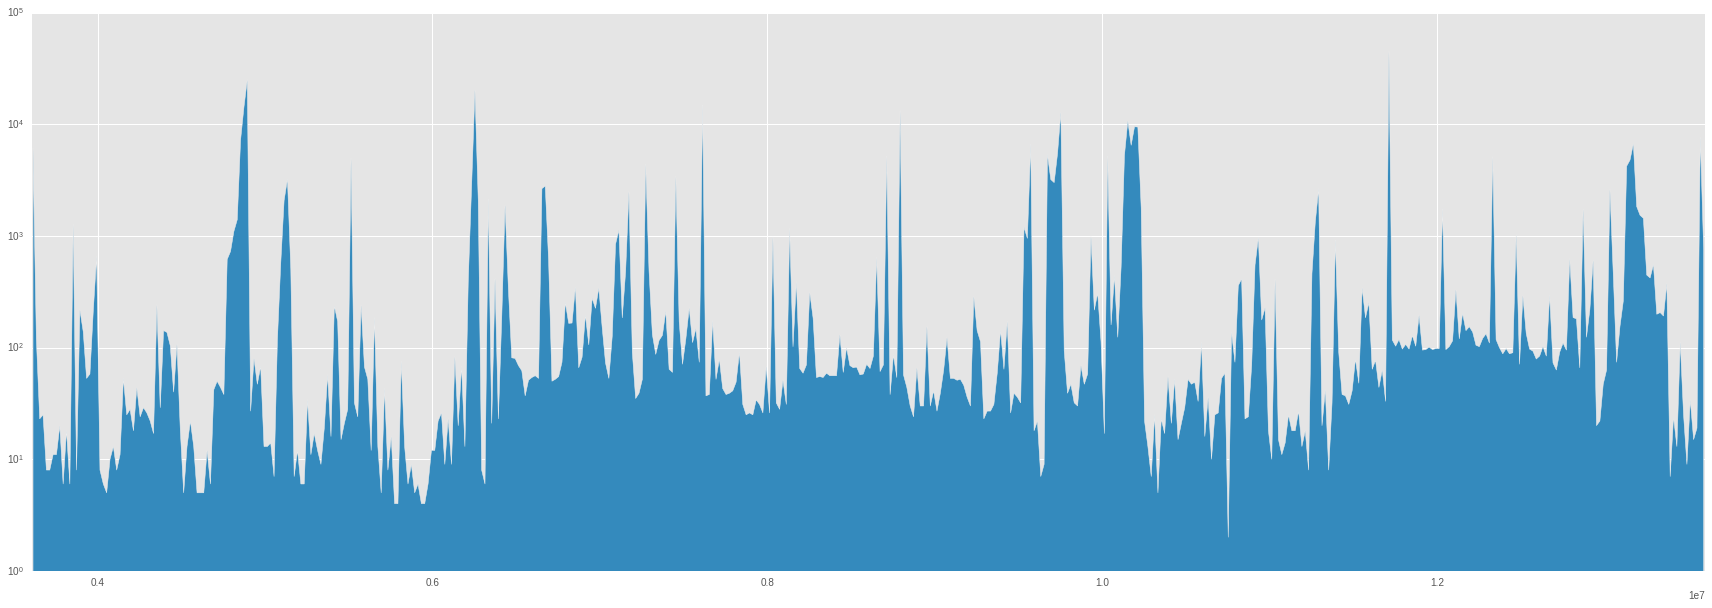

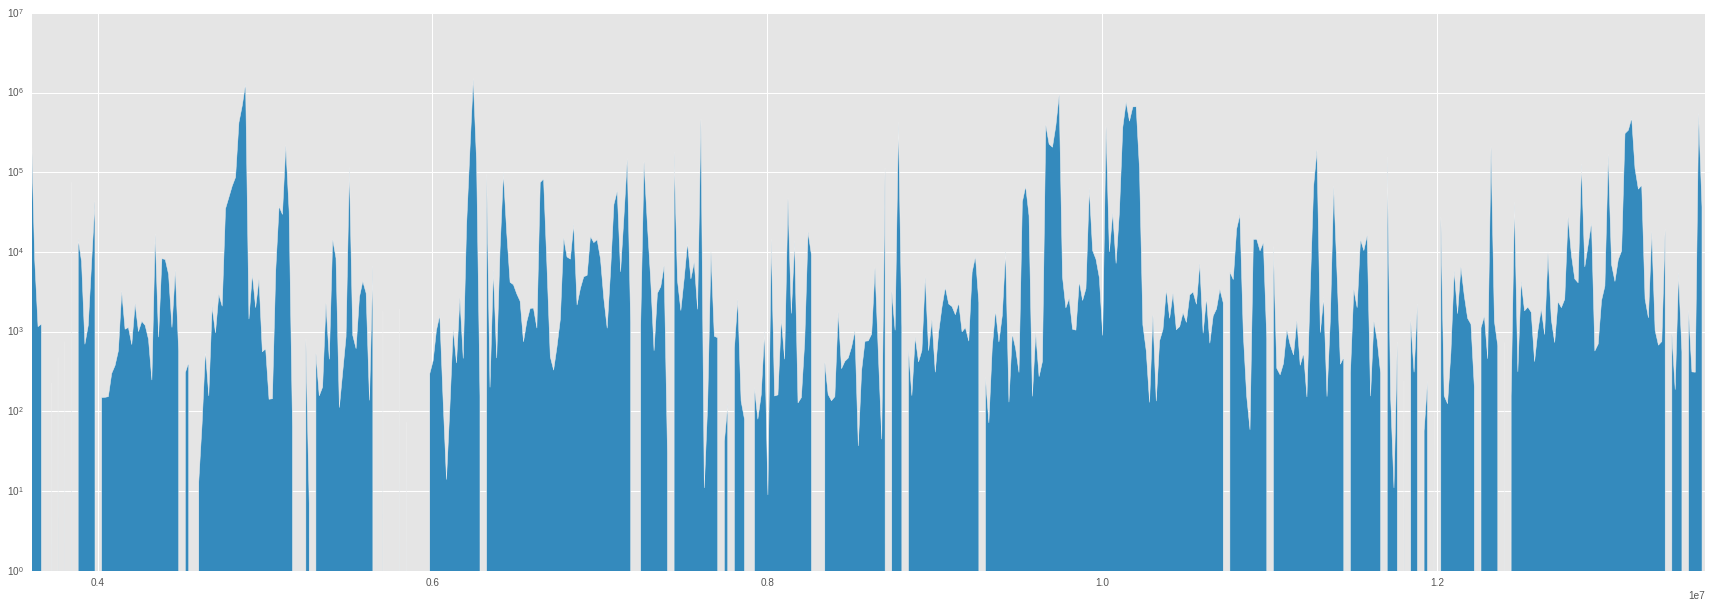

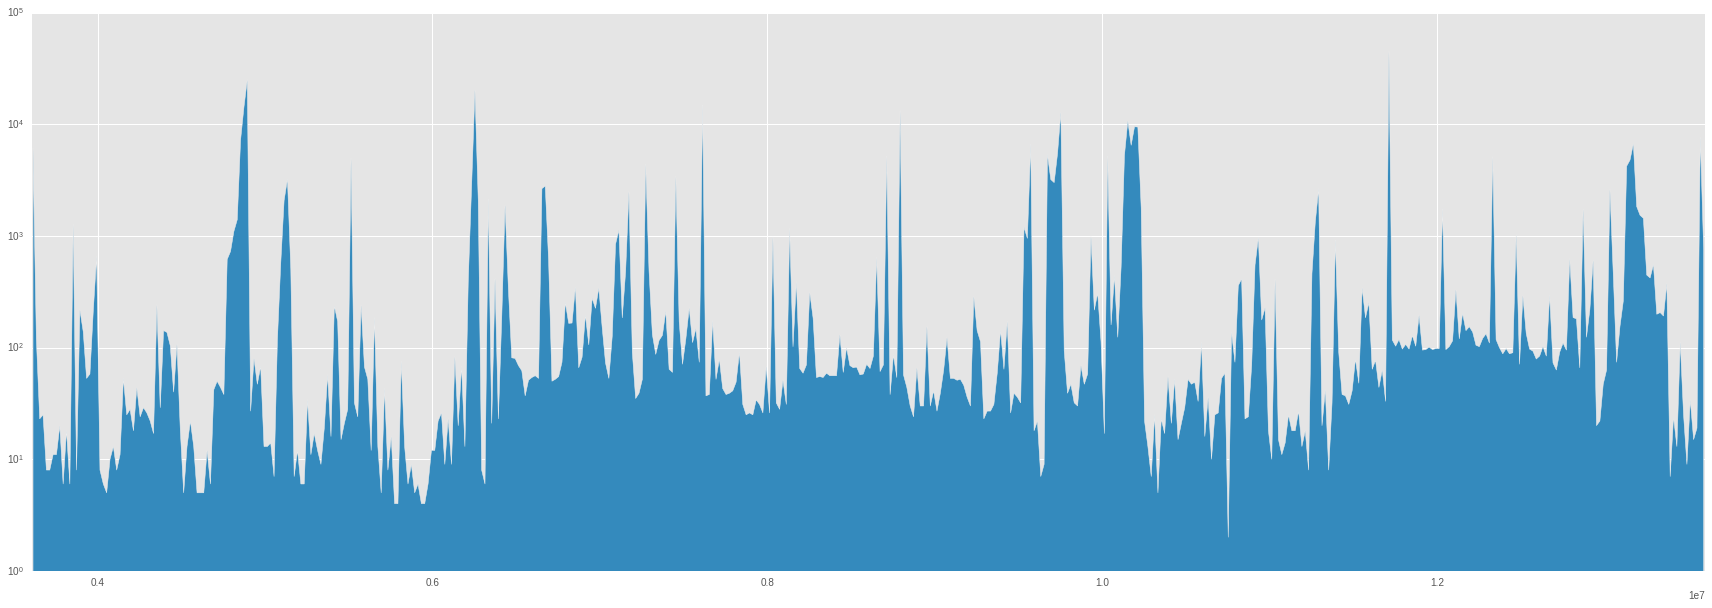

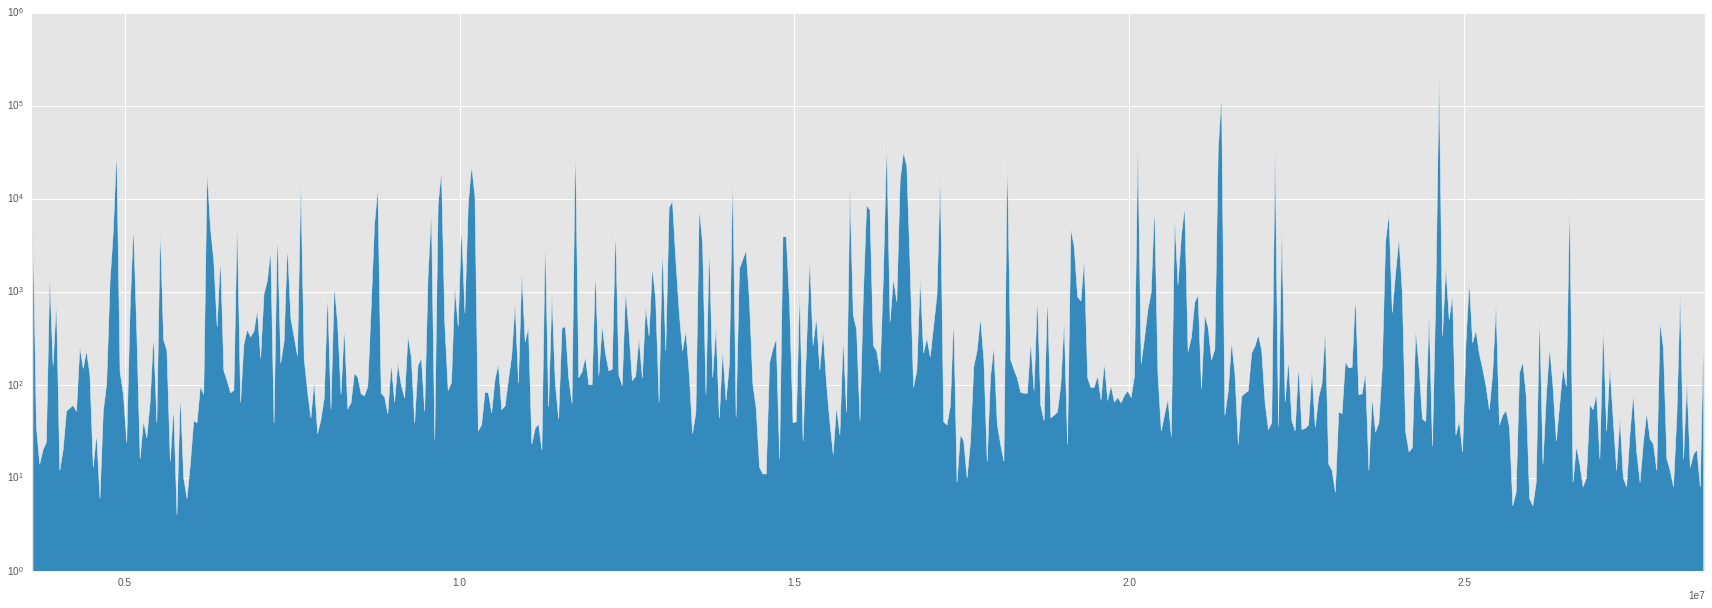

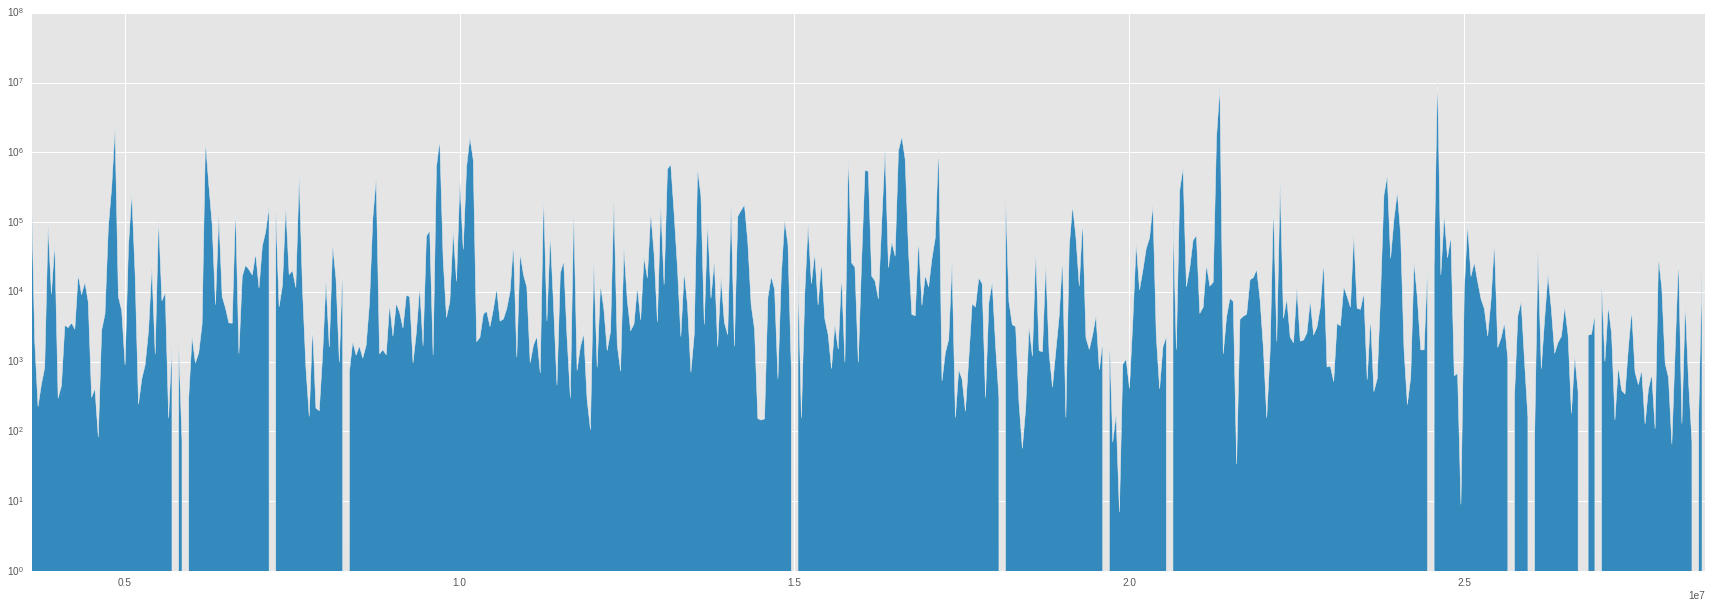

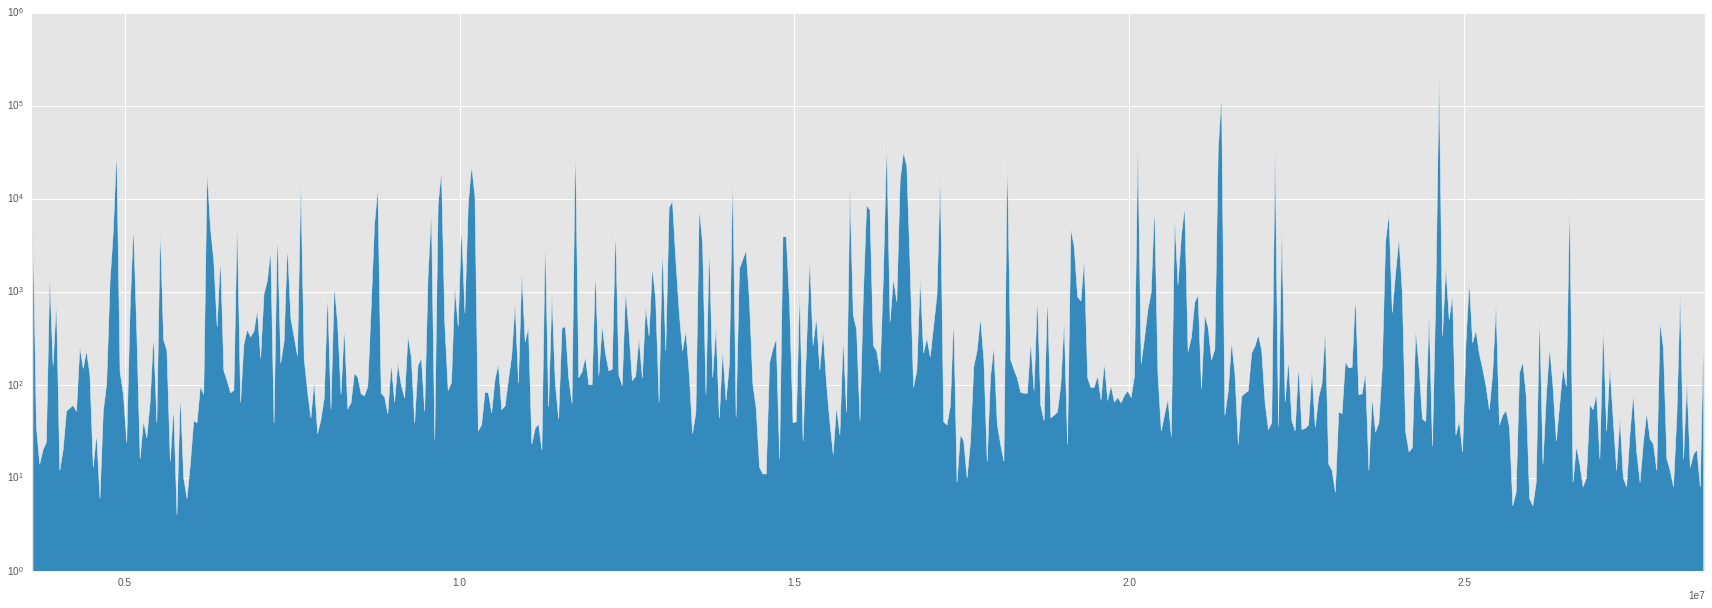

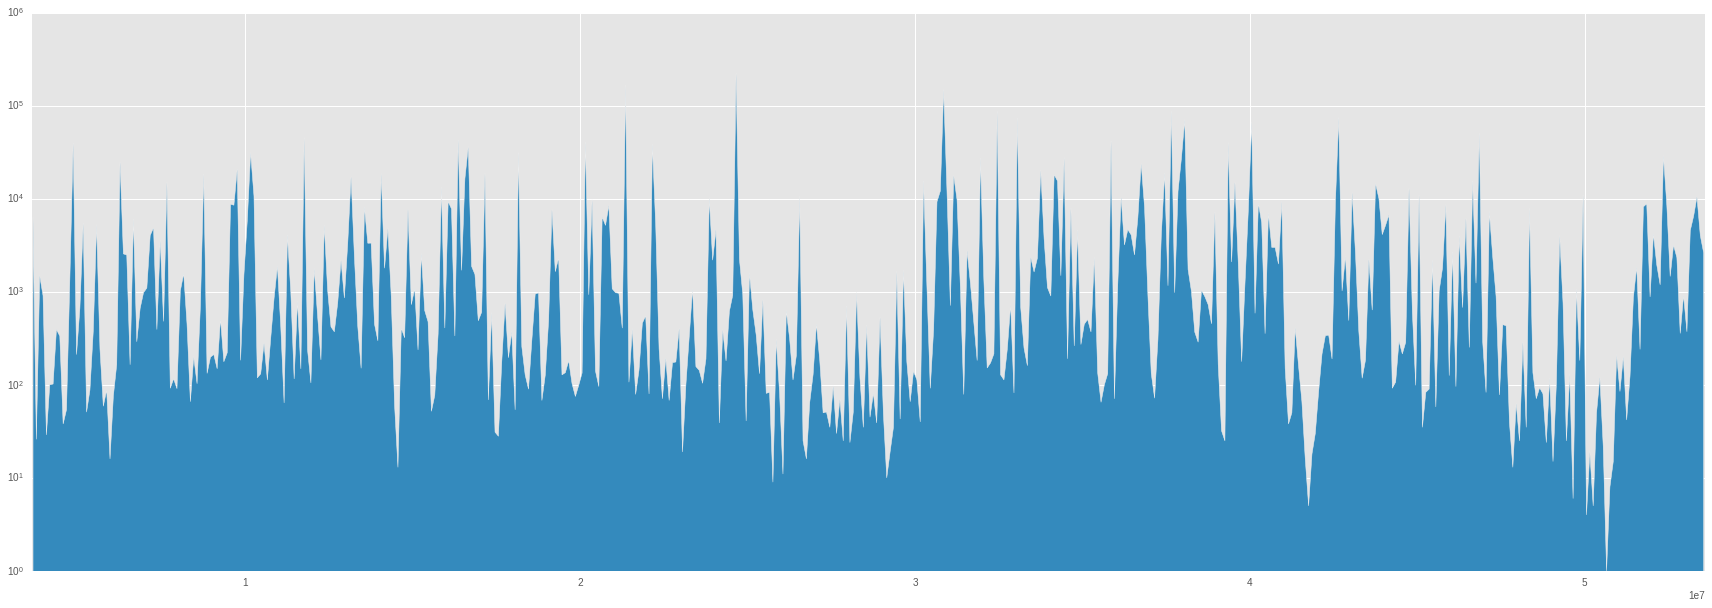

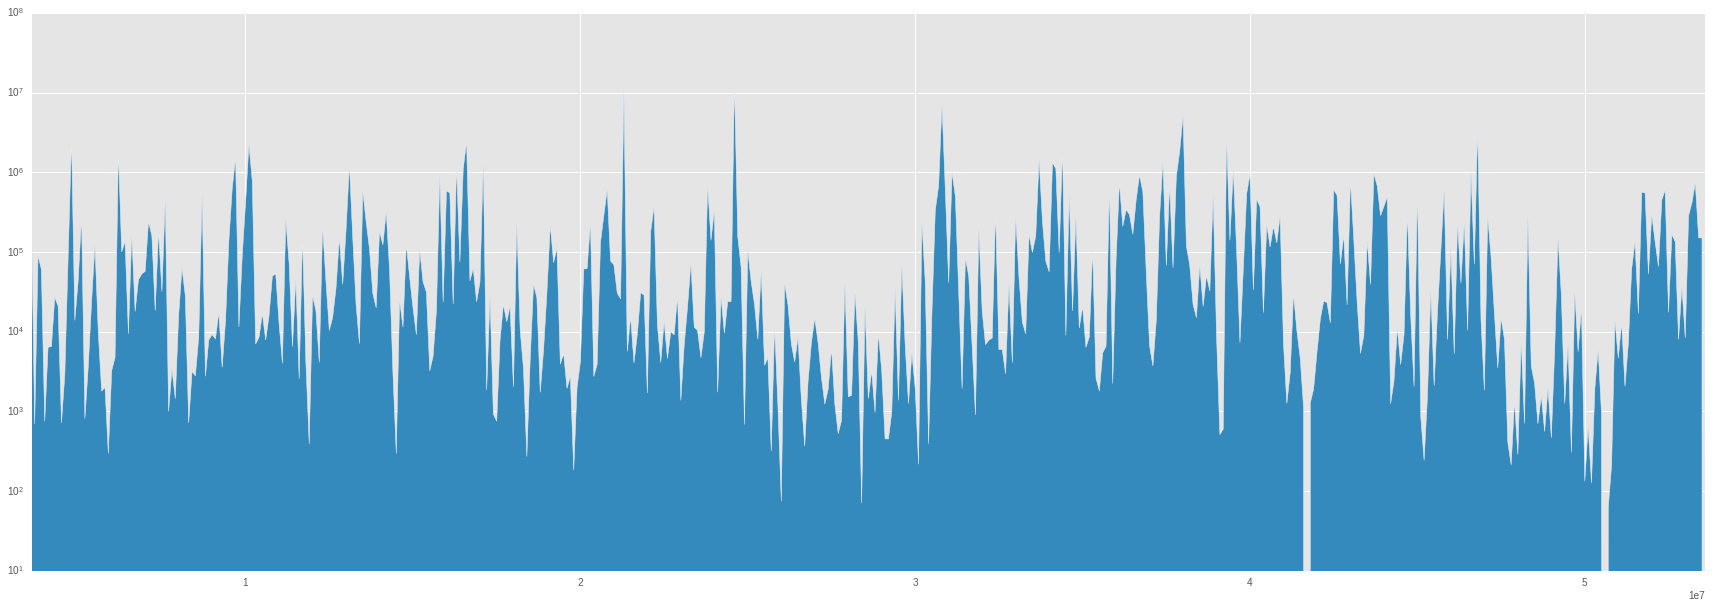

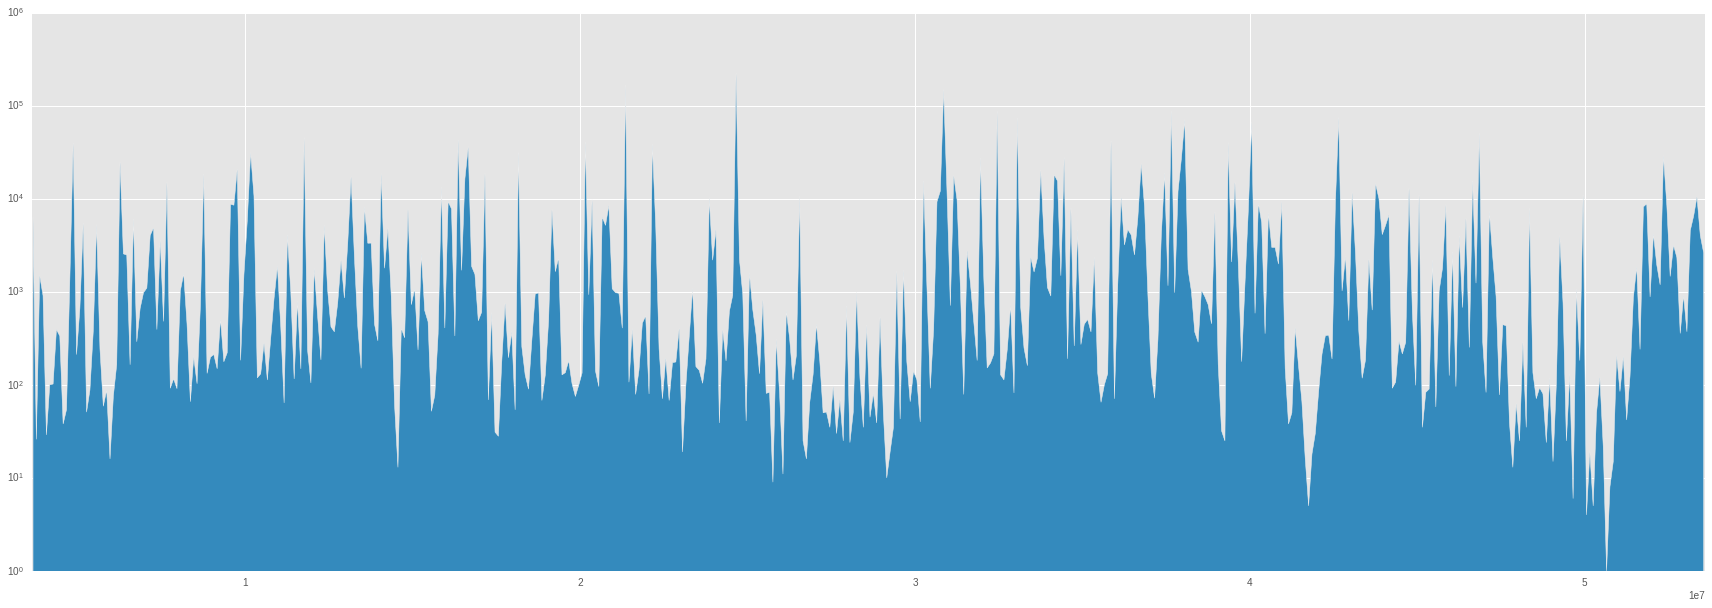

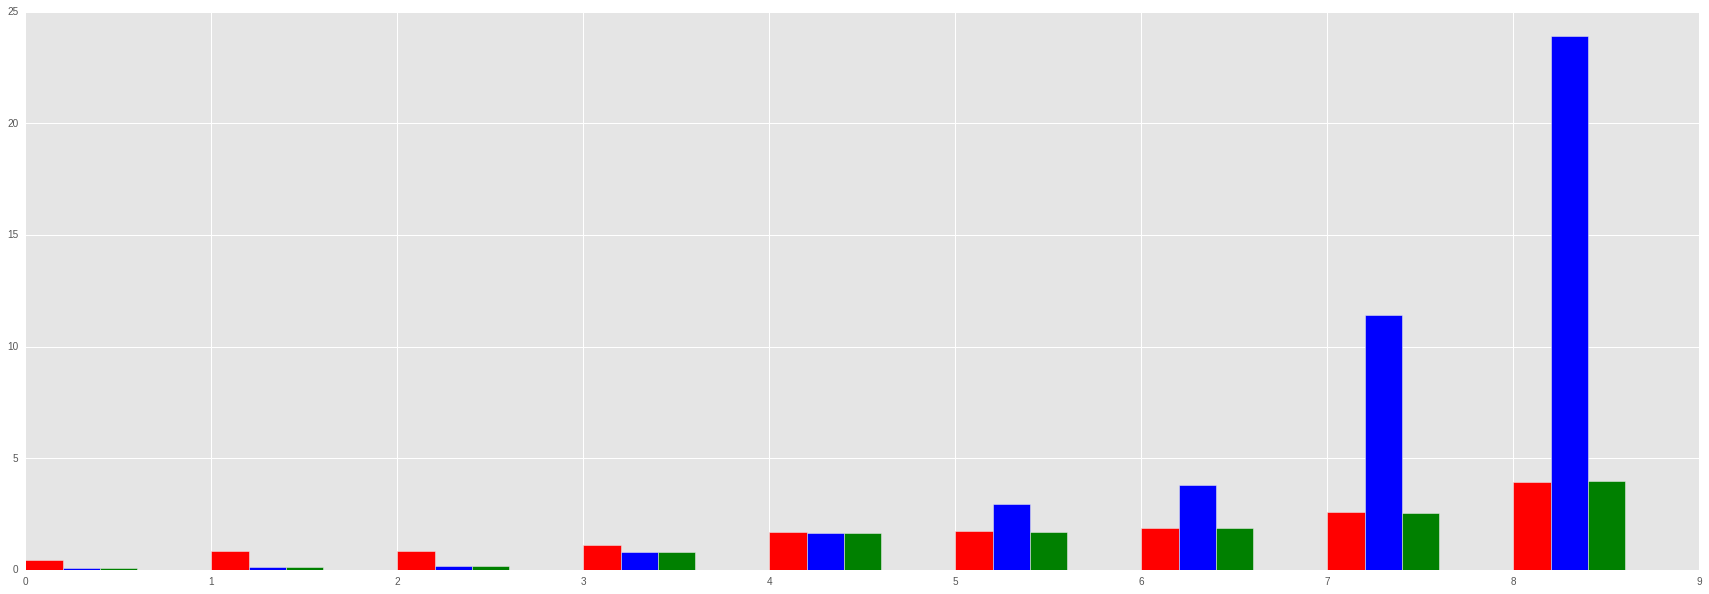

In [216]:
b = "./test_data/out.bam"

t1 = []
t2 = []
t3 = []
start = 3604000
end_list = [10000, 100000, 1000000, 2000000, 5000000, 7500000, 10000000, 25000000, 50000000]
width = 0.2

for end in end_list:
    t=time()
    plot_alignments(fp=b, seqid="chr1", start=start, end=start+end, n_step=500, yscale="log", plot_style="ggplot")
    t1.append(time()-t)
    t=time()
    plot_alignments2(fp=b, seqid="chr1", start=start, end=start+end, n_step=500, yscale="log", plot_style="ggplot")
    t2.append(time()-t)
    t=time()
    plot_alignment_hybrid(fp=b, seqid="chr1", start=start, end=start+end, n_step=500, yscale="log", plot_style="ggplot")
    t3.append(time()-t)

figure, subplot = pl.subplots(figsize=(30, 10), frameon=False)
subplot.bar(np.arange(len(end_list)), t1, width, color="r")
subplot.bar(np.arange(len(end_list))+width, t2, width, color="b")
subplot.bar(np.arange(len(end_list))+2*width, t3, width, color="g")

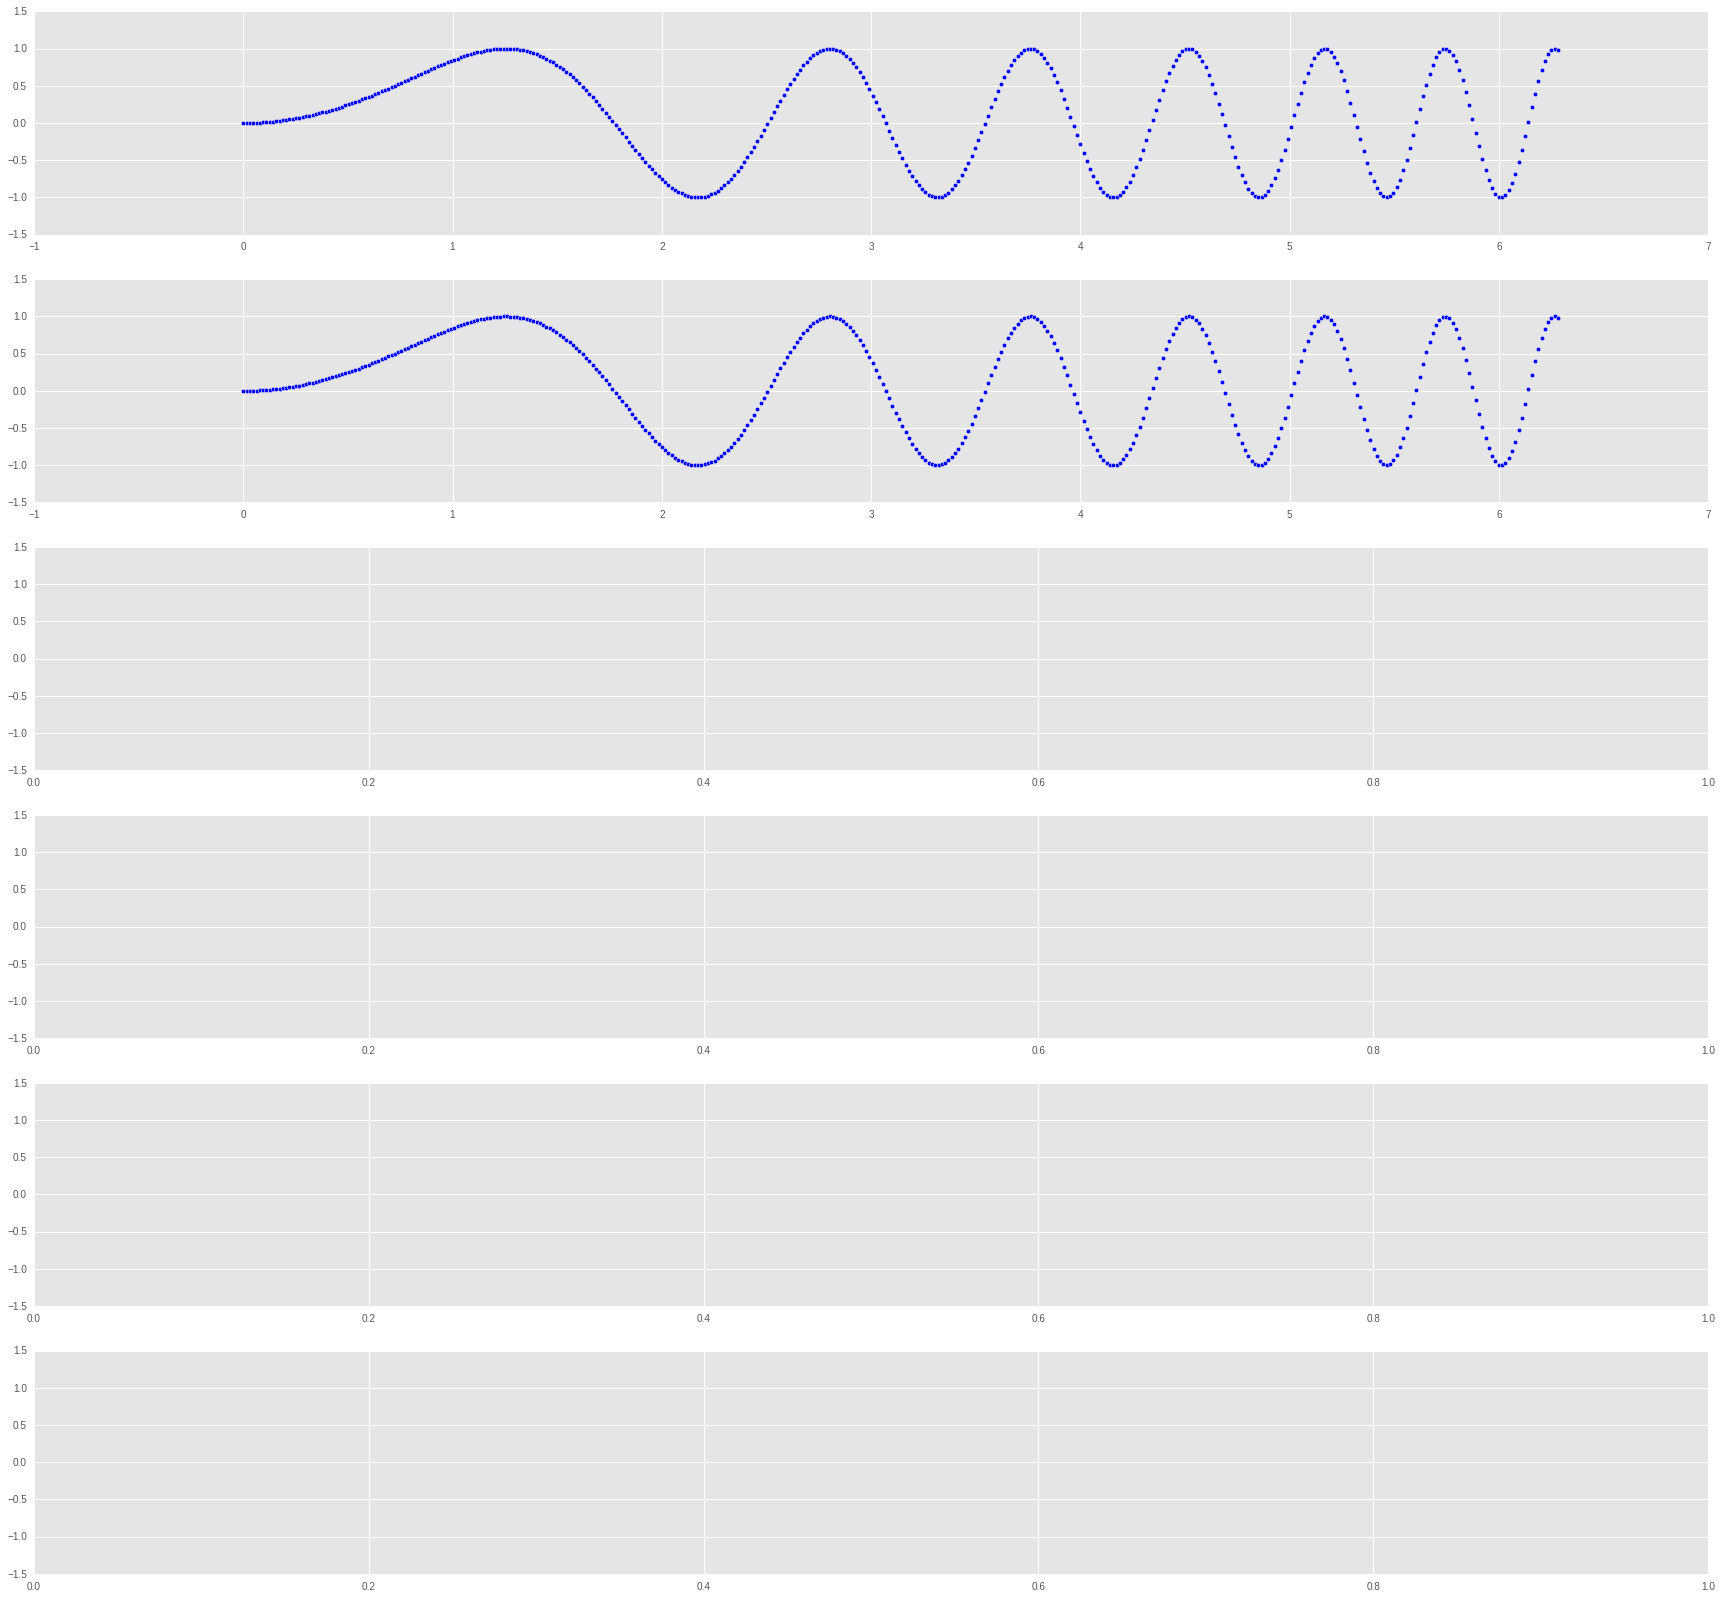

In [85]:
# make figure with subplots

b = 2
b_height = 10
g = 4
g_height = 2

h = b*b_height + g*g_height

gs = GridSpec(3, 3)

f, ax = pl.subplots(b+g, 1, sharey=True, figsize=(30,h))
create_subplot(ax[0:2])

In [34]:
import matplotlib.gridspec as gridspec

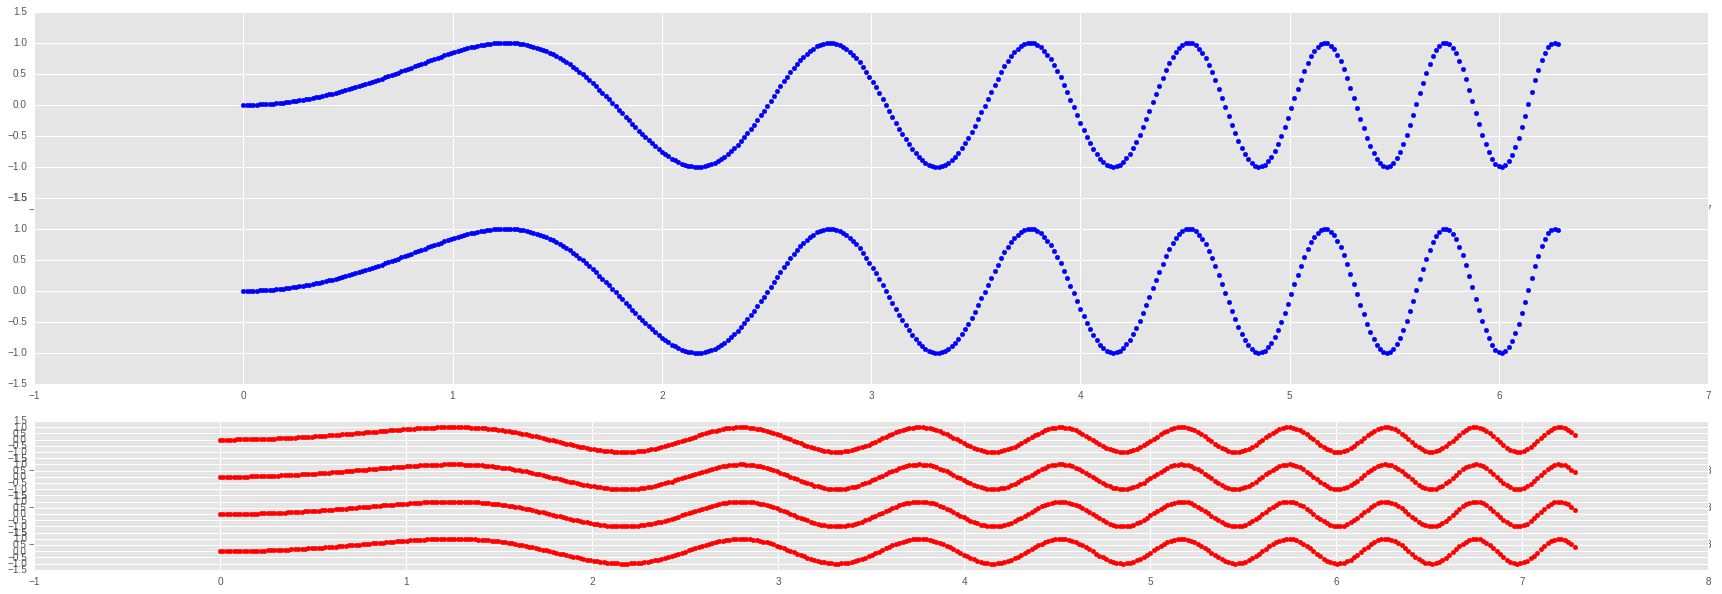

In [101]:
def create_subplot(ax, offset, color):
    for a in ax:
        x = np.linspace(0, 2*np.pi+offset, 400)
        y = np.sin(x ** 2)
        a.scatter(x,y, color=color)

b = 2
b_height = 10
g = 4
g_height = 2

h = b*b_height + g*g_height +2

pl.style.use("ggplot")
fig = pl.figure(figsize=(30,10), frameon=False)
gs = GridSpec(h, 1, hspace=0)
i=0

b_ax = [] 
for n in range(b):
    b_ax.append(pl.subplot(gs[i:i+b_height]))
    i+=b_height

sp = pl.subplot(gs[i:i+2])
sp.axis("off")
i+=2
    
g_ax = []
for n in range(g):
    g_ax.append(pl.subplot(gs[i:i+g_height]))
    i+=g_height

create_subplot(b_ax, 0, "b")
create_subplot(g_ax, 1, "r")

In [9]:
a=False

print("TRUE") if a else print("FALSE")

FALSE


In [21]:
import pysam
fp = "./test_data/gencode_v25_long_noncoding_RNAs_sorted.gff3.gz"
gff = pysam.TabixFile(fp, parser=pysam.asGTF())
gff_iter = gff.fetch()
a = next(gff_iter)
print(a)

chr1	HAVANA	exon	29554	30039	.	+	.	ID=exon:ENST00000473358.1:1;Parent=ENST00000473358.1;gene_id=ENSG00000243485.4;transcript_id=ENST00000473358.1;gene_type=lincRNA;gene_status=KNOWN;gene_name=MIR1302-2;transcript_type=lincRNA;transcript_status=KNOWN;transcript_name=MIR1302-2-001;exon_number=1;exon_id=ENSE00001947070.1;level=2;transcript_support_level=5;tag=not_best_in_genome_evidence,dotter_confirmed,basic;havana_gene=OTTHUMG00000000959.2;havana_transcript=OTTHUMT00000002840.1


---

## Refactoring the external helper functions

In [2]:
def extensions (fp):
    """ 
    Return the extension of a file in lower-case. If archived file "gz" the method will output the base extension + the archive extension
    """
    split_name = fp.split("/")[-1].split(".")
    # No extension ? 
    if len (split_name) == 1:
        return []
    # Manage compressed files
    elif len (split_name) > 2 and split_name[-1].lower() == "gz":
        return [split_name[-2].lower(), split_name[-1].lower()]
    # Normal situation = return the last element of the list
    else:
        return [split_name[-1].lower()]
    
def file_basename (fp):
    """ 
    Return the base name of a file without extension nor If archived file "gz" the method will output the name without extension + the archive extension
    """
    split_name = fp.split("/")[-1].split(".")
    # No extension ? 
    if len (split_name) == 1:
        return split_name[0]
    # Manage compressed files
    elif len (split_name) > 2 and split_name[-1].lower() == "gz":
        return ".".join(split_name[0:-2])
    # Normal situation = return the last element of the list
    else:
        return ".".join(split_name[0:-1])
    
def dir_path (fp):
    """ 
    Return the directory path of a file
    """
    return fp.rpartition("/")[0]

In [7]:
for fp in glob ("./test_data/*"):
    print (fp)
    print (extensions(fp))
    print (file_basename(fp))
    print (dir_path(fp))
    print()

./test_data/1M_sample.bam
['bam']
1M_sample
./test_data

./test_data/GRCh38_primary_index.tsv
['tsv']
GRCh38_primary_index
./test_data

./test_data/GRCh38_primary.fa.gz
['fa', 'gz']
GRCh38_primary
./test_data

./test_data/gencode_v25_primary.gff3.gz
['gff3', 'gz']
gencode_v25_primary
./test_data



---

## Refactoring the Annotation methods in a separate class

In [20]:
# Strandard library imports
from collections import OrderedDict, namedtuple, Counter
from os import access, R_OK
import csv

# Third party import
import pysam
import pandas as pd

# Local lib import
from JGV_helper_fun import *


class Annotation(object):

    #~~~~~~~FUNDAMENTAL METHODS~~~~~~~#
    
    def __init__ (self, fp, name, verbose=False):
        """
         * fp
            A standard gff3 file (http://www.ensembl.org/info/website/upload/gff3.html) or gtf
            (http://www.ensembl.org/info/website/upload/gff.html)containing features annotations. Could be uncompressed or archived in gz
            format. Ideally the  file would be already indexed with tabix bgzip. If not the program will sort the features and index the 
            file (can take time)
        *  name
            Name of the data file that will be used as track name for plotting. If not given, will be inferred from the file name
        * verbose
            If True, will print more information during initialisation and calls of all the object methods.
        """
        #Save self variable
        self.name=name
        self.verbose=verbose
        
        # Verify that the file is readable
        if not access(fp, R_OK):
            raise IOError ("{} is not readable".format(fp))
        
        # Define file format and attributes field parser 
        if extensions(fp)[0] == "gtf":
            self.format = "gtf"
            self.get_ID = self._get_gtf_ID
        elif extensions(fp)[0] == "gff3":
            self.format = "gff3"
            self.get_ID = self._get_gff3_ID
        else:
            raise ValueError ("The file is not in gtf or gff3 format (.gff3.gz, .gff3, .gtf.gz, .gtf). Please provide a correctly formated file")
        
        # Save the file path list
        self.fp = fp
        
        # If not indexed, sort and compress and index the original file with tabix 
        if not access(fp+".tbi", R_OK):
           
            # Import in a panda dataframe, remove empty rows, and convert coordinates in integer
            if self.verbose:  print("Indexing file with tabix\n\tImport annotation file and clean data")
            df = pd.read_csv(fp, names=["seqname","source","feature","start","stop","score","strand","frame","attribute"], sep="\t")
            df.dropna(inplace=True)
            df[['start', 'stop']] = df[['start', 'stop']].astype(int)
            
            # Sort the dataframe
            if self.verbose: print("\tSort lines by coordinates")
            df.sort_values(by=["seqname","start","stop"], inplace=True)
            
            # Remove the extension, name the output file and write in file
            if self.verbose: print("\tWrite a new sorted annotation file")
            temp_file = "{}/{}_sorted.{}".format(dir_path(fp), file_basename(fp),extensions(fp)[0])
            df.to_csv(temp_file, sep="\t", header=False, index=False, quoting=csv.QUOTE_NONE)
            
            # Compress and index the sorted file with tabix
            if self.verbose: print("\tCompress and index with tabix")
            self.fp = pysam.tabix_index(temp_file, preset="gff", force=True)
            
    def __str__(self):
        """readeable description of the object"""
        msg = "{} instance\n".format(self.__class__.__name__) 
        msg+= "\tParameters list\n"
        # list all values in object dict in alphabetical order
        sorted_d = OrderedDict(sorted(self.__dict__.items(), key=lambda t: t[0]))
        for k,v in sorted_d.items():
            msg+="\t{}\t{}\n".format(k, v)
        return (msg)
        
    #~~~~~~~PROPERTY METHODS~~~~~~~#
        
    @property
    def seqid_count(self):
        """List of all the sequence ids found in the annotation file"""
        with pysam.TabixFile(self.fp, parser=pysam.asGTF()) as tbf:
            c = Counter()
            for line in tbf.fetch():
                c[line.contig]+=1
        df = pd.DataFrame.from_dict(c, orient='index', dtype=int)
        df.columns = ['count']
        df.sort_values(by="count", inplace=True, ascending=False)
        return df

    @property
    def feature_type_count(self):
        """List of all the feature types found in the annotation file"""
        with pysam.TabixFile(self.fp, parser=pysam.asGTF()) as tbf:
            c = Counter()
            for line in tbf.fetch():
                c[line.feature]+=1
        df = pd.DataFrame.from_dict(c, orient='index', dtype=int)
        df.columns = ['count']
        df.sort_values(by="count", inplace=True, ascending=False)
        return df
    
    #~~~~~~~PRIVATE METHODS~~~~~~~#
    
    def _get_gtf_ID (self, line):
        """
        Parse a gtf line and extract the feature ID corresponding to the feature type of the line, if possible.
        If not found, then an empty string will be returned.
        """
        if line.feature == "exon":
            id_field = "exon_id"
        elif line.feature == "CDS":
            id_field = "cdsid"
        elif line.feature == "transcript":
            id_field = "transcript_id"
        elif line.feature == "gene":
            id_field = "gene_id"
        else:
            return ""
        
        for a in line.attributes.strip().split(";"):           
            if a:
                l = a.strip().split(" ")
                if len(l) == 2:
                    if l[0] ==  id_field:
                        return l[1][1:-1]
        return ""

    def _get_gff3_ID (self, line):
        """
        Parse a gff3 line and extract the feature ID.
        If not found, then an empty string will be returned.
        """
        for a in line.attributes.strip().split(";"):
            if a:
                l = a.strip().split("=")
                if len(l) == 2:
                    if l[0] == "ID":
                        return l[1]
        return ""

    #~~~~~~~PUBLIC METHODS~~~~~~~#

    def get_interval (self, seqid, start=None, end=None, feature_types=[]):
        """
        Parse the annotation file for the given seqid and interval and return a feature level dictionary containing a list of NamedTuples
        for each original line in the gff or gtf file. Each features are identified by their ID for gff3 file. For gtf file the ID is given
        only for exon, cds, transcript or genes if found.
        * seqid
            Name of the sequence from the initial fasta file to display
        * start
            Start of the window to display. If not given will start from 0 [ DEFAULT: None ]
        * end
            End of the window to display. If not given will start from end of the sequence [ DEFAULT: None ]
        * feature_types
            List of features types for which a track will be displayed if at least 1 feature of this type was found in the requested
            interval ( "exon"|"transcript"|"gene"|"CDS"...). If not given, all features type found in the interval will be displayed
            [ DEFAULT: [] ]
        """
        # Init dataframe to collect data
        
        feature_dict = OrderedDict()
        feature = namedtuple('feature', ["ID","start","end","strand","frame"])
 
        # Iterate over the indexed file containing the features
        with pysam.TabixFile(self.fp, parser=pysam.asGTF()) as f:
            
            for line in f.fetch(seqid, start, end, parser=pysam.asGTF()):
                if not feature_types or line.feature in feature_types:
                    
                    if not line.feature in feature_dict:
                        feature_dict[line.feature] = []
                    
                    feature_dict[line.feature].append(feature(
                            self.get_ID (line),
                            line.start,
                            line.end,
                            line.strand,
                            line.frame))
                    
            if self.verbose:
                for k,v in feature_dict.items():
                    print ("{}: {}".format(k, len(v)))
            
            return feature_dict

In [173]:
a = Annotation("./test_data/gencode_v25_primary.gff3", "gencode_v25_gff3", verbose=True)
print(a)
display(a.seqid_count.head())
display(a.feature_type_count.head())

Indexing file with tabix
	Import annotation file and clean data
	Sort lines by coordinates
	Write a new sorted annotation file
	Compress and index with tabix
Annotation instance
	Parameters list
	format	gff3
	fp	./test_data/gencode_v25_primary_sorted.gff3.gz
	get_ID	<bound method Annotation._get_gff3_ID of <__main__.Annotation object at 0x7fcd89ab5ac8>>
	name	gencode_v25_gff3
	verbose	True



,count
chr1,231881
chr2,192231
chr17,164876
chr19,163209
chr3,159916


,count
exon,1183020
CDS,705063
transcript,198160
five_prime_UTR,142512
three_prime_UTR,134018


In [174]:
a = Annotation("./test_data/gencode_v25_primary.gtf.gz", "gencode_v25_gtf", verbose=True)
print(a)
display(a.seqid_count.head())
display(a.feature_type_count.head())

Indexing file with tabix
	Import annotation file and clean data
	Sort lines by coordinates
	Write a new sorted annotation file
	Compress and index with tabix
Annotation instance
	Parameters list
	format	gtf
	fp	./test_data/gencode_v25_primary_sorted.gtf.gz
	get_ID	<bound method Annotation._get_gtf_ID of <__main__.Annotation object at 0x7fcdbb1955f8>>
	name	gencode_v25_gtf
	verbose	True



,count
chr1,232138
chr2,192370
chr17,165020
chr19,163413
chr3,160060


,count
exon,1183020
CDS,704391
UTR,279786
transcript,198160
start_codon,82679


In [51]:
a = Annotation("./test_data/NONCODE2016_human_hg38_lncRNA.gtf.gz", "noncode_2016", verbose=True)
print(a)
display(a.seqid_count.head())
display(a.feature_type_count.head())

Indexing file with tabix
	Import annotation file and clean data
	Sort lines by coordinates
	Write a new sorted annotation file
	Compress and index with tabix
Annotation instance
	Parameters list
	format	gtf
	fp	./test_data/NONCODE2016_human_hg38_lncRNA_sorted.gtf.gz
	name	noncode_2016
	verbose	True



,count
chr2,71850
chr1,71180
chr6,48917
chr3,48041
chr5,45530


,count
exon,605359
transcript,233696


In [222]:
f = "./test_data/gencode_v25_primary_sorted.gff3.gz"
h(f, 5, i)
a = Annotation(, "gencode", verbose=True)
a.get_interval("chr1", 120000, 150000)

transcript: 12
gene: 6
exon: 21


OrderedDict([('transcript',
              [feature(ID='ENST00000466430.5', start=89294, end=120932, strand='-', frame='.'),
               feature(ID='ENST00000477740.5', start=92229, end=129217, strand='-', frame='.'),
               feature(ID='ENST00000471248.1', start=110952, end=129173, strand='-', frame='.'),
               feature(ID='ENST00000610542.1', start=120724, end=133723, strand='-', frame='.'),
               feature(ID='ENST00000453576.2', start=129080, end=133566, strand='-', frame='.'),
               feature(ID='ENST00000442987.3', start=131024, end=134836, strand='+', frame='.'),
               feature(ID='ENST00000494149.2', start=135140, end=135895, strand='-', frame='.'),
               feature(ID='ENST00000595919.1', start=137681, end=137965, strand='-', frame='.'),
               feature(ID='ENST00000493797.1', start=139789, end=140339, strand='-', frame='.'),
               feature(ID='ENST00000484859.1', start=141473, end=149707, strand='-', frame='.'),
    

In [225]:
a = Annotation("./test_data/gencode_v25_primary_sorted.gff3.gz", "gencode", verbose=True)
l= a.get_interval("chr1")

exon: 108417
gene: 5194
transcript: 17296
start_codon: 7004
CDS: 65024
stop_codon: 6626
five_prime_UTR: 11627
three_prime_UTR: 10684
stop_codon_redefined_as_selenocysteine: 9


In [220]:
b = Annotation("./test_data/gencode_v25_primary_sorted.gtf.gz", "noncode", verbose=True)
print(b)
b.get_interval("chr1", 120000, 150000)

Annotation instance
	Parameters list
	format	gtf
	fp	./test_data/gencode_v25_primary_sorted.gtf.gz
	get_ID	<bound method Annotation._get_gtf_ID of <__main__.Annotation object at 0x7fcd531f9f98>>
	name	noncode
	verbose	True

transcript: 12
gene: 6
exon: 21


OrderedDict([('transcript',
              [feature(ID='"ENST00000466430.5"', start=89294, end=120932, strand='-', frame='.'),
               feature(ID='"ENST00000477740.5"', start=92229, end=129217, strand='-', frame='.'),
               feature(ID='"ENST00000471248.1"', start=110952, end=129173, strand='-', frame='.'),
               feature(ID='"ENST00000610542.1"', start=120724, end=133723, strand='-', frame='.'),
               feature(ID='"ENST00000453576.2"', start=129080, end=133566, strand='-', frame='.'),
               feature(ID='"ENST00000442987.3"', start=131024, end=134836, strand='+', frame='.'),
               feature(ID='"ENST00000494149.2"', start=135140, end=135895, strand='-', frame='.'),
               feature(ID='"ENST00000595919.1"', start=137681, end=137965, strand='-', frame='.'),
               feature(ID='"ENST00000493797.1"', start=139789, end=140339, strand='-', frame='.'),
               feature(ID='"ENST00000484859.1"', start=141473, end=149707, strand='

In [219]:
a = Annotation("./test_data/NONCODE2016_human_hg38_lncRNA_sorted.gtf.gz", "noncode", verbose=True)
a.get_interval("chr1", 100000, 120000)

transcript: 6
exon: 6


OrderedDict([('transcript',
              [feature(ID='"NONHSAT000019.1"', start=89294, end=120932, strand='-', frame='.'),
               feature(ID='"NONHSAT000019.2"', start=89294, end=120932, strand='-', frame='.'),
               feature(ID='"NONHSAT000018.1"', start=89294, end=237877, strand='-', frame='.'),
               feature(ID='"NONHSAT000018.2"', start=89294, end=268126, strand='-', frame='.'),
               feature(ID='"NONHSAT000021.1"', start=110952, end=129173, strand='-', frame='.'),
               feature(ID='"NONHSAT000021.2"', start=110952, end=129173, strand='-', frame='.')]),
             ('exon',
              [feature(ID='', start=110952, end=111357, strand='-', frame='.'),
               feature(ID='', start=110952, end=111357, strand='-', frame='.'),
               feature(ID='', start=112699, end=112804, strand='-', frame='.'),
               feature(ID='', start=112699, end=112804, strand='-', frame='.'),
               feature(ID='', start=112699, end=11

#### Test all from the class file in which I pushed the code

In [1]:
from JGV_Annotation import Annotation
from IPython.core.display import display, HTML, Markdown, Image
from pycl import head as h

In [4]:
a = Annotation("./test_data/gencode_v25_primary.gff3.gz", "gencode25", verbose=True)
a.get_features("chr8", 1000000, 1200000)

Indexing file with tabix
	Import annotation file and clean data
	Sort lines by coordinates
	Write a new sorted annotation file
	Compress and index with tabix
transcript: 7
gene: 2
exon: 6


OrderedDict([('transcript',
              [feature(ID='ENST00000637795.1', start=737595, end=1701406, strand='+', frame='.'),
               feature(ID='ENST00000522092.5', start=737650, end=1137777, strand='+', frame='.'),
               feature(ID='ENST00000421627.7', start=822178, end=1701406, strand='+', frame='.'),
               feature(ID='ENST00000524139.5', start=883197, end=1032931, strand='+', frame='.'),
               feature(ID='ENST00000578889.1', start=883327, end=1105066, strand='+', frame='.'),
               feature(ID='ENST00000634128.1', start=1018756, end=1019704, strand='+', frame='.'),
               feature(ID='ENST00000520524.5', start=1104881, end=1262580, strand='+', frame='.')]),
             ('gene',
              [feature(ID='ENSG00000198010.12', start=737595, end=1708474, strand='+', frame='.'),
               feature(ID='ENSG00000282692.1', start=1018756, end=1019704, strand='+', frame='.')]),
             ('exon',
              [feature(ID='exon:ENST00

In [5]:
a = Annotation("./test_data/gencode_v25_primary.gtf.gz", "gencode25", verbose=True)
a.get_features("chr8", 1000000, 1200000)

Indexing file with tabix
	Import annotation file and clean data
	Sort lines by coordinates
	Write a new sorted annotation file
	Compress and index with tabix
transcript: 7
gene: 2
exon: 6


OrderedDict([('transcript',
              [feature(ID='ENST00000637795.1', start=737595, end=1701406, strand='+', frame='.'),
               feature(ID='ENST00000522092.5', start=737650, end=1137777, strand='+', frame='.'),
               feature(ID='ENST00000421627.7', start=822178, end=1701406, strand='+', frame='.'),
               feature(ID='ENST00000524139.5', start=883197, end=1032931, strand='+', frame='.'),
               feature(ID='ENST00000578889.1', start=883327, end=1105066, strand='+', frame='.'),
               feature(ID='ENST00000634128.1', start=1018756, end=1019704, strand='+', frame='.'),
               feature(ID='ENST00000520524.5', start=1104881, end=1262580, strand='+', frame='.')]),
             ('gene',
              [feature(ID='ENSG00000198010.12', start=737595, end=1708474, strand='+', frame='.'),
               feature(ID='ENSG00000282692.1', start=1018756, end=1019704, strand='+', frame='.')]),
             ('exon',
              [feature(ID='ENSE0000212

In [6]:
a = Annotation("./test_data/NONCODE2016_human_hg38_lncRNA.gtf.gz", "noncode", verbose=True)
a.get_features("chr8", 1000000, 1200000)

Indexing file with tabix
	Import annotation file and clean data
	Sort lines by coordinates
	Write a new sorted annotation file
	Compress and index with tabix
transcript: 11
exon: 14


OrderedDict([('transcript',
              [feature(ID='NONHSAT124629.1', start=687586, end=1087777, strand='+', frame='.'),
               feature(ID='NONHSAT124629.2', start=737586, end=1137777, strand='+', frame='.'),
               feature(ID='NONHSAT124633.1', start=833327, end=1055066, strand='+', frame='.'),
               feature(ID='NONHSAT124632.2', start=883197, end=1032931, strand='+', frame='.'),
               feature(ID='NONHSAT124633.2', start=883327, end=1105066, strand='+', frame='.'),
               feature(ID='NONHSAT124635.2', start=896658, end=1032871, strand='+', frame='.'),
               feature(ID='NONHSAT124637.1', start=1054881, end=1212580, strand='+', frame='.'),
               feature(ID='NONHSAT216697.1', start=1087898, end=1088629, strand='-', frame='.'),
               feature(ID='NONHSAT124637.2', start=1104881, end=1262580, strand='+', frame='.'),
               feature(ID='NONHSAT215311.1', start=1104882, end=1262581, strand='+', frame='.'),
        

---

## Refactoring the Alignment methods in a separate class

In [92]:
# Strandard library imports
from time import time
from collections import OrderedDict, namedtuple, Counter
from os import access, R_OK
import csv
from statistics import median, mean

# Third party import
import pysam
import pandas as pd

# Local lib import
from JGV_helper_fun import *

class Alignment(object):

    #~~~~~~~FUNDAMENTAL METHODS~~~~~~~#
    
    def __init__ (self, fp, name, verbose=False):
        """
         * fp
             A standard bam file already SORTED BY COORDINATES (http://samtools.sourceforge.net/SAM1.pdf) containing aligned reads.
             Ideally the file would also be already indexed with samtools index. If not the program will index the file (can take time)
        *  name
            Name of the data file that will be used as track name for plotting.
        * verbose
            If True, will print more information during initialisation and calls of all the object methods.
        """
        #Save self variable
        self.name=name
        self.verbose=verbose
        
        # Verify that the file is readable
        if not access(fp, R_OK):
            raise IOError ("{} is not readable".format(fp))

        # Verify that the file is in bam format
        if extensions(fp)[0] != "bam":
            raise ValueError ("The file is not in BAM format (.bam). Please provide a correctly formated file")
        
        with pysam.AlignmentFile(fp) as bam:
            # If not bam index available
            if not bam.has_index():
                # Verify if file is sorted
                if bam.header["HD"]['SO'] == "coordinate":
                    if self.verbose: print ("Indexing bam file with samtools index")
                    pysam.index(fp, catch_stdout=False)
                else:
                    raise UserWarning ("The bam file needs to be sorted by coordinates to be processed")
        
         # The index should be available at this stage
        with pysam.AlignmentFile(fp) as bam:
            assert bam.has_index(), "Bam file is not indexed ?"       
        
        # Save the file path list
        self.fp = fp
            
    def __str__(self):
        """readable description of the object"""
        msg = "{} instance\n".format(self.__class__.__name__) 
        msg+= "\tParameters list\n"
        # list all values in object dict in alphabetical order
        sorted_d = OrderedDict(sorted(self.__dict__.items(), key=lambda t: t[0]))
        for k,v in sorted_d.items():
            msg+="\t{}\t{}\n".format(k, v)
        return (msg)
        

    #~~~~~~~PRIVATE METHODS~~~~~~~#
    
    def _len_seqid (self, seqid):
        """ Calculate the length of a seqid reference from the index metadata """
        with pysam.AlignmentFile(self.fp, "rb") as bam:
            for reference, length in zip(bam.references, bam.lengths):
                if seqid == reference:
                    return length
        return 0
    
    #~~~~~~~PUBLIC METHODS~~~~~~~#
    
    def seqid_read_density (self):
        """
        Return a dataframe containing 3 colums ("length", "read_count", "read_density") for all seq_id reference sequence in the BAM file.
        The read count is computationally intensive and can takes time for large BAM files
        """
        df = pd.DataFrame(columns=["length", "read_count", "read_density"])
        
        with pysam.AlignmentFile(self.fp, "rb") as bam:
            for seqid, length in zip(bam.references, bam.lengths):
                read_count = bam.count(seqid)
                df.at[seqid] = [length, read_count, read_count/length]
        
        return df.sort_values(by="length", ascending=False)

    def interval_coverage (self, seqid, start=None, end=None, n_step=500, mode="auto"):
        """
        Parse the alignment file for a given seqid and interval. Compute the coverage at read level in mode "read_count" or at base level
        in mode "base_coverage". In both case the interval is splited in a number of windows equal to n_step, for which the coverage in computed.
        The method return a tuple of 2 synchronised lists containing the starting positions of the windows and the coverage.
        * seqid
            Name of the sequence from the initial fasta file to display
        * start
            Start of the window to display. If not given will start from 0 [ DEFAULT: None ]
        * end
            End of the window to display. If not given will start from end of the sequence [ DEFAULT: None ]
       * n_step
            Number of alignment count bins to divide the displayed window. Low number will result in low resolution but will be faster. The
            default value is a decent compromise between speed and precision [ DEFAULT: 500 ]
        * mode
            Mode to parse and represent the alignment track ("auto"|"read_count"|"base_coverage"). The "read_count" is fast for large
            regions, but do not account for spliced reads. In "auto" mode it is automatically selected for intervals larger than 5000000.
            The "base_coverage" mode compute the median base coverage per step. It is faster for low coverage and small intervals.
            In "auto" mode it is automatically selected for intervals larger smaller than 5000000 [ DEFAULT: "auto" ]
        """
        
        # Init lists to collect data
        pos_list = []
        cov_list = []
        
        #Auto define start and stop if not given
        if not start:
            start = 0
            if self.verbose: print ("Autodefine start position: {}".format(start))
        if not end:
            end = self._len_seqid(seqid)
            if self.verbose: print ("Autodefine end position: {}".format(end))
        
        # Autocorect the number of steps if needed to be always superior or equal to the requested interval
        len_range = end-start
        if n_step > len_range:
            if self.verbose: warnings.warn("Short interval = autocorect n_step to {}".format(n_step))
            n_step = len_range
            
        step_size = (end-start) / float(n_step)

        # Read_count method, quicker for long intervals
        if mode == "read_count" or (mode == "auto" and len_range > 5000000):
            if self.verbose: print("Select read_count mode") 
            
            start_pos = start
            with pysam.AlignmentFile(self.fp) as bam:
                for i in range(n_step):

                    pos_list.append(round(start_pos))
                    cov_list.append(bam.count(seqid, start_pos, start_pos+step_size))

                    start_pos+=step_size

        # Coverage method, quicker for short intervals
        elif mode == "base_coverage" or (mode == "auto" and len_range <= 5000000):
            if self.verbose: print("Select base_coverage mode")
            with pysam.AlignmentFile(self.fp) as bam:
                mat = bam.count_coverage(seqid, start, end)
                
                start_pos = 0
                while start_pos <= len_range-step_size:
                    
                    s = round(start_pos)
                    e = round(start_pos+step_size)

                    pos_list.append(round(start+start_pos))
                    cov_list.append(sum(mat[0][s:e])+sum(mat[1][s:e])+sum(mat[2][s:e])+sum(mat[3][s:e]))

                    start_pos+=step_size
        
        # Return a tuple of the 2 lists
        return (pos_list, cov_list)
        

In [93]:
f= "./test_data/10M_sample.bam"
a = Alignment(f, "10M", verbose=True)
print(a)

display(a.seqid_read_density())

Alignment instance
	Parameters list
	fp	./test_data/10M_sample.bam
	name	10M
	verbose	True



,length,read_count,read_density
1,248956422,1327178,0.00533097
2,242193529,1260838,0.00520591
3,198295559,1014540,0.0051163
4,190214555,379040,0.0019927
5,181538259,388248,0.00213866
6,170805979,807234,0.00472603
7,159345973,514746,0.00323037
X,156040895,447450,0.00286752
8,145138636,366340,0.00252407
9,138394717,562340,0.00406331


In [97]:
f= "./test_data/10M_sample.bam"
a = Alignment(f, "10M", verbose=True)
print(a)

pos_list, cov_list = a.interval_coverage("1")

for pos, cov in zip(pos_list, cov_list):
    if cov>10000:
        print ( pos, cov )

Alignment instance
	Parameters list
	fp	./test_data/10M_sample.bam
	name	10M
	verbose	True

Autodefine start position: 0
Autodefine end position: 248956422
Select read_count mode
0 22598
497913 65068
995826 95863
1493739 18319
7966606 10460
8464518 14339
16431124 176477
17426950 16216
18920688 32099
21410252 10789
43318417 13379
54770413 10920
70205711 12560
109540826 17915
146884289 16341
150867592 10511
153855069 11286
154850894 25607
155846720 17089
156344633 12501
159830023 10263
160825849 18426
230533647 24359


#### Test all from the class file in which I pushed the code

In [2]:
from JGV_Alignment import Alignment
from IPython.core.display import display, HTML, Markdown, Image
from pycl import head as h

In [3]:
f= "./test_data/10M_sample.bam"
a = Alignment(f, "10M", verbose=True)
print(a)

display(a.seqid_read_density())

pos_list, cov_list = a.interval_coverage("X")
for pos, cov in zip(pos_list, cov_list):
    if cov>10000:
        print ( pos, cov )

Alignment instance
	Parameters list
	fp	./test_data/10M_sample.bam
	name	10M
	verbose	True



,length,read_count,read_density
1,248956422,1327178,0.00533097
2,242193529,1260838,0.00520591
3,198295559,1014540,0.0051163
4,190214555,379040,0.0019927
5,181538259,388248,0.00213866
6,170805979,807234,0.00472603
7,159345973,514746,0.00323037
X,156040895,447450,0.00286752
8,145138636,366340,0.00252407
9,138394717,562340,0.00406331


Autodefine start position: 0
Autodefine end position: 156040895
Select read_count mode
18724907 39322
23718216 16649
47124350 12982
52741823 25572
71466730 39822
133571006 13851
153544241 25384
154168404 35495


---

## Refactoring the Reference methods in a separate class

In [91]:
# Strandard library imports
from collections import OrderedDict, Counter
from os import access, R_OK
import gzip
import sys
import csv

# Third party import
import pandas as pd

# Local lib import
from JGV_helper_fun import *

#~~~~~~~CLASS~~~~~~~#

class Reference(object):
    
    #~~~~~~~FUNDAMENTAL METHODS~~~~~~~#
    
    def __init__ (self, fp, name=None, verbose=False):
        """
         * fp
             A standard bam file already SORTED BY COORDINATES (http://samtools.sourceforge.net/SAM1.pdf) containing aligned reads.
             Ideally the file would also be already indexed with samtools index. If not the program will index the file (can take time)
        *  name
            Name of the data file that will be used as track name for plotting.
        * verbose
            If True, will print more information during initialisation and calls of all the object methods.
        """
        #Save self variable
        self.name= name if name else file_basename(fp)
        self.verbose=verbose
        
        # Verify that the file is readable
        if not access(fp, R_OK):
            raise IOError ("{} is not readable".format(fp))
        
        # If the file is in fasta format
        if extensions(fp)[0] in ["fa", "fasta"]:
            if self.verbose: print ("Parsing fasta file")
            
            # File handling for both uncompressed or compressed fasta file
            if fp.endswith(".gz"):
                open_fun, open_mode = gzip.open, "rt"
            else:
                open_fun, open_mode = open, "r"
            
            # Parse fasta file seqid and count the length of each sequence 
            with open_fun(fp, open_mode) as f:
                c = Counter()
                for l in f:
                    if l.startswith(">"):
                        seqid = l[1:].split()[0].strip()
                    else:
                        c[seqid]+=len(l.strip())
            
            # Transform the counter in a Dataframe and sort by length 
            self.seq_list =  pd.DataFrame.from_dict(c, orient='index', dtype=int)
            self.seq_list.columns = ['length']
            self.seq_list.index.name = 'seqid'
            self.seq_list.sort_values(by="length", inplace=True, ascending=False)
            
            # Write the index in a file for quicker loading next time
            index_file = "{}/{}.tsv".format(dir_path(fp), file_basename(fp))
            if self.verbose: print ("Write a fasta index file: {}".format(index_file))
            self.seq_list.to_csv(index_file, sep="\t", header=False, index=False, quoting=csv.QUOTE_NONE)
            
        # In the case the file is not in fasta format, try to parse it as a 2 columns tabulated file with seqid and length for each sequence
        else:
            if self.verbose: print ("Assume the file is a fasta index")
            self.seq_list = pd.read_csv (fp, usecols=[0,1], sep ="\t", names=["seqid", "length"], index_col=0)
            self.seq_list.sort_values(by="length", inplace=True, ascending=False)
        
        if self.verbose: print("Total number of sequences found: {}".format(len(self.seq_list)))
            
            
    def __str__(self):
        """readable description of the object"""
        msg = "{} instance\n".format(self.__class__.__name__) 
        msg+= "\tParameters list\n"
        # list all values in object dict in alphabetical order
        sorted_d = OrderedDict(sorted(self.__dict__.items(), key=lambda t: t[0]))
        for k,v in sorted_d.items():
            msg+="\t{}\t{}\n".format(k, v)
        return (msg)

In [92]:
a = Reference("./test_data/GRCh38_primary.fa.gz", verbose =True)
a.seq_list

Parsing fasta file
Write a fasta index file: ./test_data/GRCh38_primary.tsv
Total number of sequences found: 194


,length
seqid,
chr1,248956422
chr2,242193529
chr3,198295559
chr4,190214555
chr5,181538259
chr6,170805979
chr7,159345973
chrX,156040895
chr8,145138636


In [17]:
print("Extract fasta and create fai index to test index mode")
!gunzip -c ./test_data/GRCh38_primary.fa.gz > ./test_data/GRCh38_primary.fa
!samtools faidx ./test_data/GRCh38_primary.fa
!ls -la ./test_data/

Extract fasta and create fai index to test index mode
total 5315260
drwxrwxr-x 2 aleg aleg       4096 Oct 22 15:12 .
drwxrwxr-x 6 aleg aleg       4096 Oct 22 15:12 ..
-rw-rw-r-- 1 aleg aleg 1094706685 Oct 18 15:25 10M_sample.bam
-rw-rw-r-- 1 aleg aleg    2245584 Oct 19 21:56 10M_sample.bam.bai
-rw-rw-r-- 1 aleg aleg  134778245 Oct 18 15:26 1M_sample.bam
-rw-rw-r-- 1 aleg aleg    1805648 Oct 19 21:50 1M_sample.bam.bai
-rw-rw-r-- 1 aleg aleg   46752876 Oct 19 17:51 gencode_v25_primary.gff3.gz
-rw-rw-r-- 1 aleg aleg   38827267 Oct 19 17:51 gencode_v25_primary.gtf.gz
-rw-rw-r-- 1 aleg aleg   60136333 Oct 19 18:06 gencode_v25_primary_sorted.gff3.gz
-rw-rw-r-- 1 aleg aleg     339199 Oct 19 18:06 gencode_v25_primary_sorted.gff3.gz.tbi
-rw-rw-r-- 1 aleg aleg   49743035 Oct 19 18:07 gencode_v25_primary_sorted.gtf.gz
-rw-rw-r-- 1 aleg aleg     338077 Oct 19 18:07 gencode_v25_primary_sorted.gtf.gz.tbi
-rw-rw-r-- 1 aleg aleg 3151417447 Oct 22 15:13 GRCh38_primary.fa
-rw-rw-r-- 1 aleg aleg       64

In [86]:
a = Reference("./test_data/GRCh38_primary.fa.fai", verbose =True)
a.seq_list

Assume the file is a fasta index
	Total number of sequences found: 194


,length
seqid,
chr1,248956422
chr2,242193529
chr3,198295559
chr4,190214555
chr5,181538259
chr6,170805979
chr7,159345973
chrX,156040895
chr8,145138636


In [ ]:
# Strandard library imports
from time import time
from collections import OrderedDict, namedtuple, Counter
from os import access, R_OK
import csv
from statistics import median, mean

# Third party import
import pysam
import pandas as pd

# Local lib import
from JGV_helper_fun import *

class Reference(object):

    #~~~~~~~FUNDAMENTAL METHODS~~~~~~~#
    
    def __init__ (self, fp, name=None, verbose=False):
        """
         * fp
             A standard bam file already SORTED BY COORDINATES (http://samtools.sourceforge.net/SAM1.pdf) containing aligned reads.
             Ideally the file would also be already indexed with samtools index. If not the program will index the file (can take time)
        *  name
            Name of the data file that will be used as track name for plotting.
        * verbose
            If True, will print more information during initialisation and calls of all the object methods.
        """
        #Save self variable
        self.name=name
        self.verbose=verbose
        self.reference = Reference(fp=fp, name=name, verbose=self.verbose)
        self.annotation_dict = OrderedDict()
        self.alignment_dict = OrderedDict()
            
    def __str__(self):
        """readable description of the object"""
        msg = "{} instance\n".format(self.__class__.__name__) 
        msg+= "\tParameters list\n"
        # list all values in object dict in alphabetical order
        sorted_d = OrderedDict(sorted(self.__dict__.items(), key=lambda t: t[0]))
        for k,v in sorted_d.items():
            msg+="\t{}\t{}\n".format(k, v)
        return (msg)
        
    
    #~~~~~~~PUBLIC METHODS~~~~~~~#
    
    def add_annotation(self):
        """
        """
        pass
    
    def add_alignement(self):
        """
        """
        pass
    
    @property
    def aligment_list (self):
        """
        """
        pass
    
    @property
    def annotation_list (self):
        """
        """
        pass
    
    
    
    def seqid_read_density (self):
        """
        """
        pass

    def interval_coverage (self, seqid, start=None, end=None, n_step=500, mode="auto"):
        """
        """
        pass
        